# Danish Politics: Tweeting vs. meeting

Authors: Christian Engelbrekt Petersen, Frederik Kromann Hansen & Lau Johansson

# Motivation

## Imports

In [3]:
import pickle
import tweepy
import re #https://developers.google.com/edu/python/regular-expressions
import pandas as pd
import numpy as np
import statistics as stat

import requests
import urllib.request
import os
import io
import json

from bs4 import BeautifulSoup as bs
from bs4.element import Comment
import lxml
import xml.etree.ElementTree as et 
from xml.dom import minidom

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches #legends
from matplotlib.lines import Line2D #circles as legends

import nltk
from nltk.collocations import *
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.corpus import words
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
#nltk.download('pos_tag')

import math
from PIL import Image
import community

from wordcloud import WordCloud, STOPWORDS
from fa2 import ForceAtlas2

#from sklearn.decomposition import NMF
#from sklearn.feature_extraction.text import TfidfVectorizer

import dateutil
import datetime as dt
from dateutil.easter import *
from dateutil.rrule import *
from dateutil.parser import *
from datetime import *

#pip install afinn
from afinn import Afinn

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/frederikkromannhansen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/frederikkromannhansen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/frederikkromannhansen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/frederikkromannhansen/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Describe datasets (goal -> what is dataset -> how does it answer goal)

### Describe Twitter  (LAU)

On [twitterpolitikere.dk](https://filip.journet.sdu.dk/twitter/politikere/), twitterprofiles of 650 danish politicians has been collected (25 november 2020). The publishers of the data is journalists Ernst Poulsen and Filip Walberg in collaboration with Center for Journalism. The website is continously updated by the publishers, where data from Twitters open APIs. Danish politicians can choose to write to the publishers to be removed from the list. Each person's profile is assessed manually before we include people on the lists. There are no information on process of assesing the profiles. If interested, this [link](https://twitter.com/ernstpoulsen/lists) has more lists with overviews of people in different industries: Politicians, journalists and people in managerial positions, etc.

From the list of danish politicians' twitternames, each of the profiles is going to represent a node in a graph that is going to be called: "Danish Politicians Twitter Network". In order to make a network which connects the danish politicians, this project uses tweets from Twitter. Initially a developer account for twitter has been created. Tweet can then be assesed through Twitters API on https://developer.twitter.com/en. [Tweets](https://help.twitter.com/en/using-twitter/types-of-tweets) are messages posted to Twitter containing text, photos, a GIF, and/or video. Both sender and receivers of tweets can see all tweets on a Home Timeline - a timeline that is different for each person - depending on who you are following. 

This project is especially interested in [mentions](https://help.twitter.com/en/using-twitter/types-of-tweets), because mentions are tweets that contains other profiles twitter usernames. A mention in a tweet is preceded by the "@" symbol - which makes it possible to examine the mentions between danish politicians. These mentions are the connections between politicians in the "Danish Politicians Twitter Network".

### Describe Politicians (parties and regions) (CHRISTIAN)

In general, politicians are segregated into different parties that align the best with their idealogies, since this is of importance to the project, we had to find a way to get these as well. In Denmark, we also have 5 main regions. If you know american politics, then you can kind off think of these as your states. As we want to investigate how politiicans interact, these labels are essential, as we wish to answer how parties interact and allign on SoMe and in folketingets meetings.

![Regioner i dk](https://rn.dk/-/media/Rn_dk/Genveje/Fakta-om-Nordjylland/Regioner-i-Danmark/Danmark_Regioner_2017.ashx?la=da)
The above image shows the regions and population in each

### Describe Political meetings (FREDERIK)

The data related to the meetings in Folketinget is collected following the guide on Folketinget's homepage:
https://www.ft.dk/-/media/sites/ft/pdf/dokumenter/aabne-data/oda-browser_brugervejledning.ashx.
Transcripts from all meetings going back to 2009 are available for download in xml format using a login described in the guide and some specific ftp software. Because it is interesting to compare topics from Twitter with topics in Folketinget, only the transcripts from the same period as the tweets are used for further analysis. 71% of the available tweets are posted in 2018 and after.

The years in Folketinget do not follow the calender year, as they start and end the first Tuesday of October. So, the meetings from 2017 are actually from October 2017 to October 2018. The data from 2017 are kept for the purpose of having slightly more data and because it is assumed that topics vary little enought for it to still be relevant.

In total 395 meeting stranscripts amounting to 218Mb of data has been downloaded and parsed for analysis.

It is not stated how the transcripts are made, however, they are proofread before publication. 

# Basic stats

## Data cleaning

### Twitterprofiles  (LAU)

Initially all of the twitterprofiles are collected using the webpage https://filip.journet.sdu.dk/twitter/politikere/.

In [2]:
import requests
from tqdm.notebook import tqdm
URL = 'https://filip.journet.sdu.dk/twitter/politikere/'
page = requests.get(URL)

In [3]:
soup = bs(page.content, 'html.parser')


After inspecting the webpage, is it concluded that all twitternames are displayed in < h3 > classes. 

In [4]:
twitter_names = soup.find_all('h3')

Creating a list to save all the twitter names.

In [5]:
twitter_name_list=[]

Scraping all of the names from the webpage:

In [6]:
"""
for names in twitter_names:
    match=re.search("<h3>#",str(names))
    if match:
        result_name=re.findall(".com/\w*",str(names))[0].replace(".com/","")
        twitter_name_list.append(result_name.rstrip())
        #print(result_name)
"""

'\nfor names in twitter_names:\n    match=re.search("<h3>#",str(names))\n    if match:\n        result_name=re.findall(".com/\\w*",str(names))[0].replace(".com/","")\n        twitter_name_list.append(result_name.rstrip())\n        #print(result_name)\n'

For each of the twitternames (twitterprofiles) a corresponding real name is shown. The real politician names are displayed in < small > classes. Initially a empty list for all the names are created.

In [7]:
real_name_list=[]

Thereafter, the webpage are scraped in order to find the realnames:

In [8]:
"""
real_names = soup.find_all('small')
for r_names in real_names:
    result=re.search(r'<small>.+',str(r_names)).group(0).replace("<small>","")
    real_name_list.append(result.rstrip())
    print(result)
"""

'\nreal_names = soup.find_all(\'small\')\nfor r_names in real_names:\n    result=re.search(r\'<small>.+\',str(r_names)).group(0).replace("<small>","")\n    real_name_list.append(result.rstrip())\n    print(result)\n'

All of the twittername with their corresponding real names are saved into a pandas dataframe.

In [9]:
d={'Names':real_name_list,"Twittername":twitter_name_list}
data=pd.DataFrame(data=d)

In [10]:
#data.to_csv("danish_politkere_twitter.csv") #For saving the file for later use

This can be used to easily load the data:

In [12]:
data=pd.read_csv("danish_politkere_twitter.csv")

In [11]:
data.head()

,Names,Twittername


### Tweets (who tags who)  (LAU)

From twitter the only profiles needed is the politicians which just have been scraped.

The twitternames are saved in a list.

In [13]:
twitter_name_list=list(data["Twittername"])

For using the API, both API key, API secret key, access token and access token-secret is needed. For privacy matter, these has been saved in files saved locally. The code below shows how the data are imported from our computers.

In [14]:
User='Lau'

In [15]:
#Load keys (everytime except first)
with open('api_key_'+User+'.data', 'rb') as filehandle:
    api_key = pickle.load(filehandle) 
with open('api_key_secret_'+User+'.data', 'rb') as filehandle:
    api_secret_key = pickle.load(filehandle)
with open('access_token_'+User+'.data', 'rb') as filehandle:
    access_token = pickle.load(filehandle)
with open('access_token_secret_'+User+'.data', 'rb') as filehandle:
    access_token_secret = pickle.load(filehandle)

For accessing twitter data, the library Tweepy has been used. Since only tweets from the politicians are needed, tweepy is very suitable for doing the job. Here is a link to the library webpage: https://www.tweepy.org/

Creating the API object which uses [OAuth](https://oauth.net/) for secure authorization. It enables interaction with the twitter API. 

In [16]:
# Creating the authentication object
auth = tweepy.OAuthHandler(api_key, api_secret_key)
# Setting access token and secret
auth.set_access_token(access_token, access_token_secret)
# Creating the API object while passing in auth information
api = tweepy.API(auth)

To give a small introduction on how it works, below 5 tweets from the politician Margrethe Vestager is printed.

In [17]:
# The Twitter user who we want to get tweets from
name = "vestager"
# Number of tweets to pull
tweetCount = 5

# Calling the user_timeline function with our parameters
tweets = api.user_timeline(id=name, count=tweetCount,tweet_mode='extended')

# foreach through all tweets pulled
for tweet in tweets:
    # printing the text stored inside the tweet object
    print(tweet.full_text)
    print(80 * '-')

RT @Forsvarsmin: Danmark medvirker til et stærkt og robust digitalt EU. 
Godt møde med @vestager om cybersikkerhed, hybride trusler,
cybers…
--------------------------------------------------------------------------------
RT @VeraJourova: Today's Media &amp; Audiovisual Action Plan
✅supports the recovery, the digital transformation of these sectors, and a level p…
--------------------------------------------------------------------------------
Time for Europe to set strong rules for the digital world for the next decade
Together with Thierry @ThierryBreton we are ready for
#DigitalServicesAct
#DigitalMarketsAct https://t.co/e4jv7FkhWs
--------------------------------------------------------------------------------
Working on technology that we can trust, free data flows, fair digital taxation. So much 🇪🇺 and 🇺🇸 can do together! https://t.co/R3jSBSHk6q And a lot of work for our future EU-US Trade &amp; Technology Council w @VDombrovskis Looking forward to working with you @Transition46 

The structure of dictionary is as follows:


* Vestager :
       Larslokke : [TweetTextA, TweetTextB] 
       oestergaard : [TweetTextC] 


Each key correspond to a politician twitter profiles e.g. Vestager. Vestager has tagged Larslokke in two tweets and oestergaard in one tweet.

In [18]:
tweet_dict={"Dummy":{}} #The dummy is deleted later

Saving all the twitterprofiles (again).

In [19]:
 all_persons=list(data["Twittername"])

The following code uses Tweepy to the last 200 tweets (the limit of the API) of each politician. 

If politician (P0) tags another politician (P1), then P1 is saved, and a corresponding list with all tweets where P0 mentions P1 is also saved.  

In [20]:
"""
n_count=0
n_total=len(all_persons)
for p in all_persons:   
    n_count=n_count+1
    print("Loading {} / {}".format(n_count,n_total))


    # The Twitter user who we want to get tweets from
    name = p
    # Number of tweets to pull
    tweetCount = 200

    #Some of the twitterprofiles may have changed twittername or deleted the profile. Therefore try/except.
    try:
        # Calling the user_timeline function with our parameters
        tweets = api.user_timeline(id=name, count=tweetCount,tweet_mode='extended')

        if name not in list(tweet_dict.keys()):
            ##Updating dict with the new politician if it is not there
            tweet_dict.update({name:{}})


        ###############========== LOOPING THROUGH ALL THE TWEET FOR THE POLITICIAN=============#####

        for i,tweet in enumerate(tweets):
    
                #Save the text
                opslag=tweet.full_text
                #Find all tagging
                match=re.findall(r"@\w+",opslag)


                if len(match)>0:
                    
                    #Loop through all tagged politican in the tweet
                    for a in range(len(match)):
                        #Remove the '@'
                        uden_snabela=str(match[a]).replace("@","")
                        
                        #If the twittername is one of the politicians then it should be saved
                        if uden_snabela in twitter_name_list:
                            
                            #If the politician P0, has not mentioned politician P1 before
                            if uden_snabela not in list(tweet_dict[name].keys()):
                                tweet_dict[name].update({uden_snabela:[opslag]})
                            #If the politician P0, HAS mentioned politician P1 before, the list is appended
                            else:
                                tweet_dict[name][uden_snabela].append(opslag)
    except:
        print("Error at {}".format(name))
"""

'\nn_count=0\nn_total=len(all_persons)\nfor p in all_persons:   \n    n_count=n_count+1\n    print("Loading {} / {}".format(n_count,n_total))\n\n\n    # The Twitter user who we want to get tweets from\n    name = p\n    # Number of tweets to pull\n    tweetCount = 200\n\n    #Some of the twitterprofiles may have changed twittername or deleted the profile. Therefore try/except.\n    try:\n        # Calling the user_timeline function with our parameters\n        tweets = api.user_timeline(id=name, count=tweetCount,tweet_mode=\'extended\')\n\n        if name not in list(tweet_dict.keys()):\n            ##Updating dict with the new politician if it is not there\n            tweet_dict.update({name:{}})\n\n\n        ###############========== LOOPING THROUGH ALL THE TWEET FOR THE POLITICIAN=============#####\n\n        for i,tweet in enumerate(tweets):\n    \n                #Save the text\n                opslag=tweet.full_text\n                #Find all tagging\n                match=re.fi

Delete the dummy:

In [21]:
#del tweet_dict["Dummy"]

Saving all data:

In [22]:
#with open('tweet_dict_listversion.data', 'wb') as filehandle:
#    # store the data as binary data stream
#    pickle.dump(tweet_dict, filehandle)

Some of the politicians could perhaps mention eachother without using the tag (@). Therefore, the amount of data is increased by including mentioning of politicians full names. Here's an example:

vestager tweets: "Morten Østergaard try to read this post, how (...)"

Morten Østergaard's twittername is oestergaard, and therefore, this tweet should be related to the twitterprofile "oestergaard". 

To attach the tweet to the corresponding twittername, the twitternames are saved in a list:

In [23]:
twitter_name_list=list(data["Twittername"])

The real names in the data is a combined of low letters and capital letters. All names are then lower-cased, and saved in a list:

In [24]:
data["Names"]=data["Names"].str.lower() ##LAVER DEM TIL LOWER
names_list=list(data["Names"])

When Morten Østergaards twittername shall be found, it can be done like this:

In [25]:
data[data["Names"]=="morten østergaard"]["Twittername"]

2    oestergaard
Name: Twittername, dtype: object

All the tweets of the politicians are then revised, and the following code adds the tweets which has a real name included:

In [26]:
"""
n_count=0
n_total=len(all_persons)
for p in all_persons:   
    n_count=n_count+1
    print("Loading {} / {}".format(n_count,n_total))


    # The Twitter user who we want to get tweets from
    name = p
    # Number of tweets to pull
    tweetCount = 200

    try:
        # Calling the user_timeline function with our parameters
        tweets = api.user_timeline(id=name, count=tweetCount,tweet_mode='extended')

        ##Updating dict, if the politician has (by some reason) been "visited" before
        if name not in list(tweet_dict.keys()):
            tweet_dict.update({name:{}})



        ###############========== FINDING TWEETS FOR PERSON=============#####

        for i,tweet in enumerate(tweets):
        
                #Save the tweet, but this time lowering the text
                opslag=tweet.full_text.lower()


                #Loop through all real names for the 650 politicians
                for real_names in names_list:
                    
                    if real_names in opslag:
                        twittername=data[data["Names"]==real_names]["Twittername"] #Find the persons twittername
                        twittername=list(twittername)[0] #"hack" for removing pandas "objecttype"


                        #If the politician P0, has not mentioned politician P1 before
                        if twittername not in list(tweet_dict[name].keys()):
                            tweet_dict[name].update({twittername:[opslag]}) 
                        else:
                            #If the politician P0, HAS mentioned politician P1 before, the list is appended
                            tweet_dict[name][twittername].append(opslag)
    except:
        print("Error at {}".format(name))
"""

'\nn_count=0\nn_total=len(all_persons)\nfor p in all_persons:   \n    n_count=n_count+1\n    print("Loading {} / {}".format(n_count,n_total))\n\n\n    # The Twitter user who we want to get tweets from\n    name = p\n    # Number of tweets to pull\n    tweetCount = 200\n\n    try:\n        # Calling the user_timeline function with our parameters\n        tweets = api.user_timeline(id=name, count=tweetCount,tweet_mode=\'extended\')\n\n        ##Updating dict, if the politician has (by some reason) been "visited" before\n        if name not in list(tweet_dict.keys()):\n            tweet_dict.update({name:{}})\n\n\n\n        ###############========== FINDING TWEETS FOR PERSON=============#####\n\n        for i,tweet in enumerate(tweets):\n        \n                #Save the tweet, but this time lowering the text\n                opslag=tweet.full_text.lower()\n\n\n                #Loop through all real names for the 650 politicians\n                for real_names in names_list:\n          

In [27]:
#Saving the data locally
#with open('tweet_dict_listversion_wrealnames.data', 'wb') as filehandle:
#    pickle.dump(tweet_dict, filehandle)

The dictionary called "tweet_dict" now contains data on (almost) all the politicians and who they have been tagging including the assosicated tweets.

During the datapreparation, some of the API calls of the twitterprofiles failed. These were:

* SosseSass -> He has changed name to SassLarsen 
* Simonpihl -> He has a private twitterprofile
* GeertsenVenstre -> He has changed name to Martin_geertsen
* BendixenPebe -> She has maybe deleted/deactivated her profile. No new profile has been found.
* ToftJakobsen -> He has maybe deleted/deactivated his profile. No new profile has been found.
* simonsjsimonsen -> He has maybe deleted/deactivated his profile. No new profile has been found.
* Latifa_Venstre -> She has maybe deleted/deactivated her profile. No new profile has been found.
* GlenMadsen -> He has maybe deleted/deactivated his profile. No new profile has been found.
* flemse68 -> He has a private twitterprofile
* SkovAndersen -> He has changed name to KristianSkov21
* rn_lehmann -> He has maybe deleted/deactivated his profile. No new profile has been found.



SosseSass, GeertsenVenstre and SkovAndersen is handled by doing the following in the dataset:

* SosseSass is changed to SassLarsen.
* GeertsenVenstre is changed to Martin_geertsen
* SkovAndersen is changed to KristianSkov21


In [28]:
data.loc[data['Twittername']=="SosseSass","Twittername"]="SassLarsen"
data.loc[data['Twittername']=="GeertsenVenstre","Twittername"]="Martin_geertsen"
data.loc[data['Twittername']=="SkovAndersen","Twittername"]="KristianSkov21"

In [29]:
three_politicians=["SassLarsen","Martin_geertsen","KristianSkov21"]

All instances of the three politicians twitter names in the dictionary should be updated too:

In [30]:
with open('tweet_dict_listversion_wrealnames_v2.data', 'rb') as filehandle:
    tweet_dict = pickle.load(filehandle) 

In [31]:
"""
for elem in list(tweet_dict.keys()):
    for elem2 in list(tweet_dict[elem].keys()):            
        if elem2=="SosseSass":
            tweet_dict[elem]["SassLarsen"] = tweet_dict[elem].pop("SosseSass")
        if elem2=="GeertsenVenstre":
            tweet_dict[elem]["Martin_geertsen"] = tweet_dict[elem].pop("GeertsenVenstre")
        if elem2=="SkovAndersen":
            tweet_dict[elem]["KristianSkov21"] = tweet_dict[elem].pop("SkovAndersen")
"""

'\nfor elem in list(tweet_dict.keys()):\n    for elem2 in list(tweet_dict[elem].keys()):            \n        if elem2=="SosseSass":\n            tweet_dict[elem]["SassLarsen"] = tweet_dict[elem].pop("SosseSass")\n        if elem2=="GeertsenVenstre":\n            tweet_dict[elem]["Martin_geertsen"] = tweet_dict[elem].pop("GeertsenVenstre")\n        if elem2=="SkovAndersen":\n            tweet_dict[elem]["KristianSkov21"] = tweet_dict[elem].pop("SkovAndersen")\n'

In [32]:
#with open('tweet_dict_listversion_wrealnames.data', 'wb') as filehandle:
    # store the data as binary data stream
#    pickle.dump(tweet_dict, filehandle)

Then the code for collecting tweets are runned again, but only focusing on the three politicians above. (The new implmentation is at codeline 40):

In [33]:
"""

n_count=0
n_total=len(all_persons)
for p in all_persons not in three_politicians:   
    n_count=n_count+1
    print("Loading {} / {}".format(n_count,n_total))


    # The Twitter user who we want to get tweets from
    name = p
    # Number of tweets to pull
    tweetCount = 200

    #Some of the twitterprofiles may have changed twittername or deleted the profile. Therefore try/except.
    try:
        # Calling the user_timeline function with our parameters
        tweets = api.user_timeline(id=name, count=tweetCount,tweet_mode='extended')

        ##Updating dict with the new politician
        if name not in list(tweet_dict.keys()):
            tweet_dict.update({name:{}})


        ###############========== LOOPING THROUGH ALL THE TWEET FOR THE POLITICIAN=============#####

        for i,tweet in enumerate(tweets):
    
                #Save the text
                opslag=tweet.full_text
                #Find all tagging
                match=re.findall(r"@\w+",opslag)


                if len(match)>0:
                    
                    #Loop through all tagged politican in the tweet
                    for a in range(len(match)):
                        #Remove the '@'
                        uden_snabela=str(match[a]).replace("@","")
                        
                        #If the twittername is one of the politicians then it should be saved
                        if uden_snabela in three_politicians:
                            
                            #If the politician P0, has not mentioned politician P1 before
                            if uden_snabela not in list(tweet_dict[name].keys()):
                                tweet_dict[name].update({uden_snabela:[opslag]})
                            #If the politician P0, HAS mentioned politician P1 before, the list is appended
                            else:
                                tweet_dict[name][uden_snabela].append(opslag)
    except:
        print("Error at {}".format(name))
"""

'\n\nn_count=0\nn_total=len(all_persons)\nfor p in all_persons not in three_politicians:   \n    n_count=n_count+1\n    print("Loading {} / {}".format(n_count,n_total))\n\n\n    # The Twitter user who we want to get tweets from\n    name = p\n    # Number of tweets to pull\n    tweetCount = 200\n\n    #Some of the twitterprofiles may have changed twittername or deleted the profile. Therefore try/except.\n    try:\n        # Calling the user_timeline function with our parameters\n        tweets = api.user_timeline(id=name, count=tweetCount,tweet_mode=\'extended\')\n\n        ##Updating dict with the new politician\n        if name not in list(tweet_dict.keys()):\n            tweet_dict.update({name:{}})\n\n\n        ###############========== LOOPING THROUGH ALL THE TWEET FOR THE POLITICIAN=============#####\n\n        for i,tweet in enumerate(tweets):\n    \n                #Save the text\n                opslag=tweet.full_text\n                #Find all tagging\n                match=r

Also adding all the politicians who the three politicians has mentioned from their new profiles (new implmentation at code line 3):

In [34]:

"""
n_count=0
n_total=len(three_politicians)
for p in three_politicians:   
    n_count=n_count+1
    print("Loading {} / {}".format(n_count,n_total))


    # The Twitter user who we want to get tweets from
    name = p
    # Number of tweets to pull
    tweetCount = 200

    #Some of the twitterprofiles may have changed twittername or deleted the profile. Therefore try/except.
    try:
        # Calling the user_timeline function with our parameters
        tweets = api.user_timeline(id=name, count=tweetCount,tweet_mode='extended')

        ##Updating dict with the new politician
        if name not in list(tweet_dict.keys()):
            tweet_dict.update({name:{}})


        ###############========== LOOPING THROUGH ALL THE TWEET FOR THE POLITICIAN=============#####

        for i,tweet in enumerate(tweets):

                #Save the text
                opslag=tweet.full_text
                #Find all tagging
                match=re.findall(r"@\w+",opslag)


                if len(match)>0:

                    #Loop through all tagged politican in the tweet
                    for a in range(len(match)):
                        #Remove the '@'
                        uden_snabela=str(match[a]).replace("@","")

                        #If the twittername is one of the politicians then it should be saved
                        if uden_snabela in all_persons:

                            #If the politician P0, has not mentioned politician P1 before
                            if uden_snabela not in list(tweet_dict[name].keys()):
                                tweet_dict[name].update({uden_snabela:[opslag]})
                            #If the politician P0, HAS mentioned politician P1 before, the list is appended
                            else:
                                tweet_dict[name][uden_snabela].append(opslag)
    except:
        print("Error at {}".format(name))
"""

'\nn_count=0\nn_total=len(three_politicians)\nfor p in three_politicians:   \n    n_count=n_count+1\n    print("Loading {} / {}".format(n_count,n_total))\n\n\n    # The Twitter user who we want to get tweets from\n    name = p\n    # Number of tweets to pull\n    tweetCount = 200\n\n    #Some of the twitterprofiles may have changed twittername or deleted the profile. Therefore try/except.\n    try:\n        # Calling the user_timeline function with our parameters\n        tweets = api.user_timeline(id=name, count=tweetCount,tweet_mode=\'extended\')\n\n        ##Updating dict with the new politician\n        if name not in list(tweet_dict.keys()):\n            tweet_dict.update({name:{}})\n\n\n        ###############========== LOOPING THROUGH ALL THE TWEET FOR THE POLITICIAN=============#####\n\n        for i,tweet in enumerate(tweets):\n\n                #Save the text\n                opslag=tweet.full_text\n                #Find all tagging\n                match=re.findall(r"@\\w+",

In [35]:
#with open('tweet_dict_listversion_wrealnames_v2.data', 'wb') as filehandle:
    # store the data as binary data stream
#    pickle.dump(tweet_dict, filehandle)

**Conlusion:** The dictionary called "tweet_dict" now contains data on all the politicians which the API could asses. Furthermore the dictionary contains information about who they have been tagging including the associated tweets.

### Tweets (only the text)  (LAU)

To faciliate the topic modelling analysis and wordcloud generation, all of the last 200 tweets from each of the politicians is saved in a dictionary. The keys are politician twitternames and the values are a list of all the tweets. 

In [36]:
#tweet_dict_onlytext={"Dummy":{}}

In [37]:
"""
n_count=0
n_total=len(all_persons)
time_vec=[] #For saving all dates for the tweets
for p in all_persons:   
    n_count=n_count+1
    print("Loading {} / {}".format(n_count,n_total))

    # The Twitter user who we want to get tweets from
    name = p
    # Number of tweets to pull
    tweetCount = 200

    try:
        # Calling the user_timeline function with our parameters
        tweets = api.user_timeline(id=name, count=tweetCount,tweet_mode='extended')

        ##Updating dict
        tweet_dict_onlytext.update({name:{}})

        ###############========== FINDING TWEETS FOR PERSON=============#####
        for i,tweet in enumerate(tweets):
            
            time_vec.append(tweet.created_at) #Save all times of the tweets
            
            opslag=tweet.full_text
            if i==0:
                tweet_dict_onlytext[name]=[opslag]
            else:
                tweet_dict_onlytext[name].append(opslag)
    except:
        print("Error at {}".format(name))     
"""

'\nn_count=0\nn_total=len(all_persons)\ntime_vec=[] #For saving all dates for the tweets\nfor p in all_persons:   \n    n_count=n_count+1\n    print("Loading {} / {}".format(n_count,n_total))\n\n    # The Twitter user who we want to get tweets from\n    name = p\n    # Number of tweets to pull\n    tweetCount = 200\n\n    try:\n        # Calling the user_timeline function with our parameters\n        tweets = api.user_timeline(id=name, count=tweetCount,tweet_mode=\'extended\')\n\n        ##Updating dict\n        tweet_dict_onlytext.update({name:{}})\n\n        ###############========== FINDING TWEETS FOR PERSON=============#####\n        for i,tweet in enumerate(tweets):\n            \n            time_vec.append(tweet.created_at) #Save all times of the tweets\n            \n            opslag=tweet.full_text\n            if i==0:\n                tweet_dict_onlytext[name]=[opslag]\n            else:\n                tweet_dict_onlytext[name].append(opslag)\n    except:\n        print(

In [38]:
#del tweet_dict["Dummy"]

In [39]:
#with open('time_vec.data', 'wb') as filehandle:
    # store the data as binary data stream
 #   pickle.dump(time_vec, filehandle)

In [40]:
#with open('tweet_dict_all_v2.data', 'wb') as filehandle:
    # store the data as binary data stream
#    pickle.dump(tweet_dict_onlytext, filehandle)

In [41]:
with open('tweet_dict_all_v2.data', 'rb') as filehandle:
    tweet_dict_onlytext = pickle.load(filehandle)

To find out what meetings that should later be used for topic modelling, the time of the tweets are used. **The meetings from the parliament should be at the (almost) same time as the most of the tweets.** (Det skal vi lige tjekke op når det hele er inde)

In [42]:
time_vec=[]
with open('time_vec.data', 'rb') as filehandle:
    # store the data as binary data stream
    time_vec=pickle.load( filehandle)

In [43]:
year_list=[n.year for n in time_vec]

In [44]:
arr=np.array(year_list)

In [45]:
np.quantile(arr,0.25)

2018.0

In [46]:
df = pd.DataFrame(arr)

from scipy import stats
100-stats.percentileofscore(df,2018)

71.50267136251468

In [47]:
100-stats.percentileofscore(df,2017)

78.63209468362922

**Conclusion:** All of the politicians respectively 200 tweets are saved in a dictionary "tweet_dict_onlytext". When making topic modelling on Parliament meetings later, we need meetings from 2018 to 2020. 71% of the tweets is from this time period. Only 7% of the tweets would be included the time period was expanded to 2017 - BUT, this would add Parliament meeting for a whole year. It was then concluded to not include 2017.

### Politicians (parties and regions) (CHRISTIAN)

#### Web scraping galore

We quickly discovered that finding a general database for danish politicans and their respective parties was a lot more difficult than what was initially thought. Since, we started with a database over twitter profile, we had to do some digging to find out more about the politician behind them.

Firstly we scraped https://www.danskepolitikere.dk/ as it was advertised to be a general database over danish politicians. However, it only consisted of current and old folketing and eropean parliament members. 

In [48]:
import requests
data = pd.read_csv("danish_politkere_twitter.csv")
data = data.drop(columns=['Unnamed: 0'])
soup = bs(requests.get('https://www.danskepolitikere.dk/oversigt/danske-politikere').content, 'html.parser')
sections = list(soup.find_all('section'))
                     
# add "UNKNOWN" as default party
data['Party'] = 'UNKNOWN'
parties = []
# cross reference for our politicians and check if he's in the party
for row, coloumns in data.iterrows(): 
    name = coloumns[0] 
    for section in sections:
        party = section.h3.a.text # gets the party 
        if re.search(name.lower(), str(section).lower()):
            data.at[row, 'Party'] = party

# view results
data.groupby('Party').count()
            


,Names,Twittername
Party,,
Alternativet,1,1
Dansk Folkeparti,13,13
Det Konservative Folkeparti,14,14
Enhedslisten,12,12
Inuit Ataqatigiit,1,1
Liberal Alliance,5,5
Radikale Venstre,15,15
Socialdemokratiet,42,42
Socialistisk Folkeparti,19,19


As observered, there's still far too many unknowns, so we had to do some digging. By manual labour, we found out that many of the politicians in this twitter database were smaller politicians outside folketinget.

So we scrabed the regions homepages and also folketinget's homepage, the scraping progress is quite tedious and therefore will just be added to the appendix. But essentially, we found that a LARGE majority of politicians are small time, inside their local "kommune" and since there are over 90 of these in denmark. We couldn't eliminate all of the unknowns so far.

Here's what we ended up with...


In [108]:
data=pd.read_csv("danish_politkere_twitter2.csv")
data.groupby('Party').count()


,Names,Twittername,Region
Party,,,
Alternativet,4,4,4
Dansk Folkeparti,21,21,21
Det Konservative Folkeparti,22,22,22
Det Radikale Venstre,1,1,1
Enhedslisten,23,23,23
Government,14,14,14
Inuit Ataqatigiit,1,1,1
Liberal Alliance,7,7,7
Nye Borgerlige,4,4,4


### Political meetings (FREDERIK)

In [ ]:
path = os.getcwd()
path = path+'/samling/'

In [ ]:
# Get a sense of the structure
for subdir, dir, files in os.walk(path):
    for file in files:
        filepath = subdir+'/' + file
        if filepath.endswith(".xml"):
            xmlTree = et.parse(filepath)
            
elemList = []

for elem in xmlTree.iter():
    elemList.append(elem.tag)

# Just printing out the result
from collections import Counter
Counter(elemList)

In [ ]:
starttid_vec = []
sluttid_vec=[]
navn_vec = []
efternavn_vec = []
tekst_vec = []
parti_vec = []
rolle_vec = []
meetingID_vec = []


# Go through all the folders and files containing transcripts
for subdir, dir, files in os.walk(path):
    for file in files:
        filepath = subdir+'/' + file
        if (filepath.endswith(".xml")) and not (filepath.endswith("clean.xml")):
            tree = et.parse(filepath)
            root = tree.getroot() 

            for meeting in root.iter('MeetingNumber'):
                meetingID = meeting.text
            # Do this if the speaker has an associated party, i.e. not a minister or the chairman
            for speech in root.iter('Tale'):

                tags=[node.tag for node in speech.iter()]
                if('TekstGruppe' in tags):
                    if('GroupNameShort' in tags):
                        for node in speech.iter():
                            if(node.tag == 'StartDateTime'):
                                starttid_vec.append(node.text)
                            elif(node.tag == 'OratorFirstName'):
                                navn_vec.append(node.text)
                            elif(node.tag == 'OratorLastName'):
                                efternavn_vec.append(node.text)
                            elif(node.tag == 'OratorRole'):
                                rolle_vec.append(node.text)
                            elif(node.tag=='TekstGruppe'):
                                # This tag is preculiar, as there are multiple children ending with 'Char' as the youngest.
                                # Concate all text within 'TekstGruppe'.
                                tekstgruppe = ''
                                for k in node.iter():
                                    if k.tag=="Char":
                                        tekstgruppe+=' '+k.text
                                tekst_vec.append(tekstgruppe)
                            elif(node.tag=='GroupNameShort'):
                                parti_vec.append(node.text)
                                
                                meetingID_vec.append(meetingID)


                            # If there are more text than speaker names, remove the excess.
                            # We will loose a few pieces of text but only around 1%
                            if len(tekst_vec)>len(navn_vec):
                                tekst_vec.pop()
                            if len(starttid_vec)>len(navn_vec):
                                starttid_vec.pop()

                    # Do this if the speaker is either a minister or the chairman
                    else:
                        parti_vec.append('Ukendt')
                        for node in speech.iter():
                            if(node.tag == 'StartDateTime'):
                                starttid_vec.append(node.text)
                            elif(node.tag == 'OratorFirstName'):
                                navn_vec.append(node.text)
                            elif(node.tag == 'OratorLastName'):
                                efternavn_vec.append(node.text)
                            elif(node.tag == 'OratorRole'):
                                rolle_vec.append(node.text)
                            elif(node.tag=='TekstGruppe'):
                                # This tag is preculiar, as there are multiple children ending with 'Char' as the youngest.
                                # Concate all text within 'TekstGruppe'.
                                tekstgruppe = ''
                                for k in node.iter():
                                    if k.tag=="Char":
                                        tekstgruppe+=' '+k.text
                                tekst_vec.append(tekstgruppe)
                                
                                meetingID_vec.append(meetingID)

                            # If there are more text than speaker names, remove the excess.
                            # We will loose a few pieces of text but only around 1%
                            if len(tekst_vec)>len(navn_vec):
                                tekst_vec.pop()
                            if len(starttid_vec)>len(navn_vec):
                                starttid_vec.pop()
                    


# Add everuthing to a dictionary and transform it into a Pandas dataframe
dictionary= {'MeetingID':meetingID_vec, 'StartDateTime':starttid_vec,'OratorFirstName':navn_vec,'OratorLastName':efternavn_vec,
                 'GroupNameShort':parti_vec,'OratorRole':rolle_vec ,'TekstGruppe':tekst_vec} # 'EndDateTime':sluttid_vec,
df = pd.DataFrame(dictionary)

print('In total, there are {} lines of text in the meetings.'.format(len(df)))
#df.to_csv(path[0:26]+'csv')

In [ ]:
### Cleaning the data ###

# The chariman (formand) does not add value to the context as he or she only moderates the debate
# by passing on the word from person to person.
# Also some meta data is contained regarding when the meeting ended (MødeSlut). This is also irrelevant.
df=df[df['OratorRole']!='formand']
df=df[df['OratorRole']!='MødeSlut']
df['OratorRole'].dropna(axis=0,inplace=True)
df.reset_index(drop=True,inplace=True)

# Generating a column of the full name of the speakers
df['FullName'] = df['OratorFirstName']+' '+df['OratorLastName']

# Making start time into datetime64 format
df['StartDateTime'] = df['StartDateTime'].apply(lambda x: dateutil.parser.parse(x))

df['MeetingID']=df['MeetingID'].apply(lambda x: int(x))
#df['ItemNo']=df['ItemNo'].apply(lambda x: int(x))

In [ ]:
df_agg_date = df.groupby([df['StartDateTime'].dt.year, df['StartDateTime'].dt.month, df['StartDateTime'].dt.day])['TekstGruppe'].apply(lambda x : ' '.join(x)).sort_index()
pd.DataFrame(df_agg_date).head()

## Topics

In [ ]:
# convert the text to a tf-idf weighted term-document matrix
from __future__ import division

# Hyperparameters
corpus = 700000 #Der er ca. 66247 forskellige ord, efter stopord
l1_ratio = 0
max_iter = 50000
no_components = 20 #number of topics

# The words should appear at least 'min_df' times and at most 'max_df' pr document. Decimals indicate proportions
min_df = 2
max_df = 0.6

data=df_agg_date

vectorizer = TfidfVectorizer(max_features=corpus, min_df=min_df, max_df=max_df, stop_words=stopwords)

X = vectorizer.fit_transform(data)
 
idx_to_word = np.array(vectorizer.get_feature_names())


# apply Non-negative Matrix Factorization to get topics using TF-IDF
nmf = NMF(n_components=no_components, solver="mu", l1_ratio = l1_ratio, max_iter = max_iter, random_state=1)

W = nmf.fit_transform(X)

H = nmf.components_
 
# print the topics
 
for i, topic in enumerate(H):
 
    print("Topic {}: {}".format(i + 1, ", ".join([str(x) for x in idx_to_word[topic.argsort()[-10:]]])))

In [ ]:
print('There are ', len(data), ' rows in this aggregation')
print('and from these, ', W.shape[1], ' topics are computed.')
print()
print('There are ', len(idx_to_word),' words in the corpus.')
print(H.shape)

In [ ]:
pd.set_option('display.float_format', lambda x: '%.8f' % x)
#pd.reset_option('display.float_format')
pd.DataFrame(W)

### Sentiment

In [ ]:
afinn = Afinn(language='da', emoticons=True)

In [ ]:
afinn.score('Hvis ikke det er det mest afskyelige flueknepperi...')

In [ ]:
df['Sentiment'] = df['TekstGruppe'].apply(lambda x: afinn.score(x))

## Preliminary statistics

### Text statistics (twitter and meetings)

#### Twitter text statistics (who mentions who) (LAU)

In [109]:
with open('tweet_dict_listversion_wrealnames_v2.data', 'rb') as filehandle:
    tweet_dict = pickle.load(filehandle) 

Using pandas dataframe to get an easier overview of the politicians and their associated mentioned politicians.

In [110]:
pd_tweet_dict=pd.DataFrame.from_dict(tweet_dict)

Transposing the dataset, so the politician who has made the tweet is represented in the rows - the ones who are mentioned are represented in coloumns. NaNs in place (i,j) means that the politician *i* does not mention politician *j*.

In [111]:
pd_tweet_dict=pd_tweet_dict.transpose()

In [112]:
pd_tweet_dict.head(2)

,SchaldemoseMEP,karmel80,oestergaard,sofiecn,vestager,simonkollerup,jesper_bedreby,RohlChristopher,Statsmin,_MaiMercado,...,Eeahaldan,8464tage,Lindaf_dk,PetterAstrup,NiniOken,KarstenUno,SimickMorten,hedlund_susan,VickyLorenzen,birgitte_vind
vestager,[#HybridDebate @SchaldemoseMEP: What is illega...,[#HybridDebate @SchaldemoseMEP: What is illega...,"[@oestergaard @radikale @sofiecn Ja, @sofiecn ...","[@oestergaard @radikale @sofiecn Ja, @sofiecn ...",[RT @NATOpress: #NATO Secretary General @jenss...,[RT @simonkollerup: Deltog i erhvervsministern...,[Opening the upper secondary section of @Schol...,[RT @RohlChristopher: Prideweek starter i dag ...,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
larsloekke,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[@CasparStrand @Statsmin Tillykke!!],[@_MaiMercado Ulækkert!],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [113]:
print("The number of Twitter profiles who is found on twitter: {}".format(pd_tweet_dict.shape[0]))

The number of Twitter profiles who is found on twitter: 643


In [114]:
print("The number of Twitter profiles who is mentioned: {}".format(pd_tweet_dict.shape[1]))

The number of Twitter profiles who is mentioned: 499


In [115]:
print("The number of distinct links between politicians: {}".format(pd_tweet_dict.count().sum()))

The number of distinct links between politicians: 10445


In [116]:
print("The number of no-links from a poltician to another: {}".format(pd_tweet_dict.isna().sum().sum()))

The number of no-links from a poltician to another: 310412


There's 310412 combinations of politicians where theres no mentioning on twitter. This indicates a very sparse matrix. When later using this as a basis for a graph, one would know that it is not a complete graph. 

The following piece of code revise the dictionary again and calculates:
* The total number of tweets accross all politicians (non-distinct, because multiple politician can be mentioned in same tweet)
* Total length of all the tweets
* A list for every politician, indicating the length of the each tweets where they mentions other politicians
* A list for every politician, indicating the total length all tweets where they mentions other politicians
* A number for every politician, indicating the total number of tweets

In [117]:
total_n_tweets=0
total_string_length=0

n_tweet_dict=dict()
tweet_lengths_all_dict=dict()
tweet_length_agg_dict=dict()

for pol in list(tweet_dict.keys()):
    
    tweet_lengths_all_dict[pol]=[]
    
    n_tweet_dict[pol]=0
    
    for to_pol in list(tweet_dict[pol].keys()):
        elems=tweet_dict[pol][to_pol]
        
        #sum over the number of words for each tweet
        elems_splittet_to_words=[elems[i].split() for i in range(len(elems))]
        total_string_length+=sum( map(len,elems_splittet_to_words  )) #Summing the total length of character
        total_n_tweets+=len(elems)                  # summing the total number of tweets
        
        n_tweet_dict[pol]+=len(elems)
        
        #Save all length of tweets
        for e in elems:
            tweet_lengths_all_dict[pol].append(len(e.split()))
            
    #Save the total amount of characters for each politician
    tweet_length_agg_dict[pol]=sum(tweet_lengths_all_dict[pol])

In [118]:
print("The total number of tweets {}".format(total_n_tweets))

The total number of tweets 33532


In [119]:
print("The average length of tweets {}".format(total_string_length/total_n_tweets))

The average length of tweets 24.760616724323036


Making a histogram over the sum of the length of all tweets for all politicians using Sturge's rule for the number of bins:

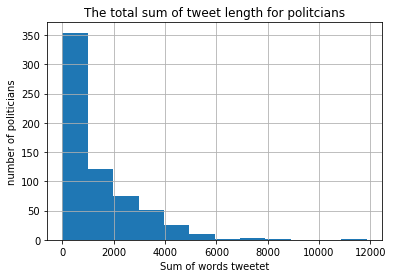

In [120]:
pd.DataFrame(tweet_length_agg_dict.values()).hist(bins=12)
plt.title("The total sum of tweet length for politcians")
plt.ylabel('number of politicians')
plt.xlabel('Sum of words tweetet')
plt.show()

Most of the politicians has a tweetet in total, where others are mentioned, between 0 and 1000 words.

Plot the distribution of the length of the tweets (again using Sturge's rule).

In [121]:
list2d=list(tweet_lengths_all_dict.values())

In [122]:
import itertools
merged = list(itertools.chain(*list2d))

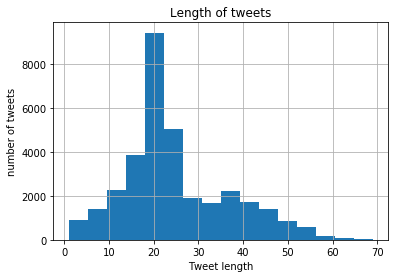

In [123]:
pd.DataFrame(merged).hist(bins=16)
plt.title("Length of tweets")
plt.ylabel('number of tweets')
plt.xlabel('Tweet length')
plt.show()

Most of the tweets where politician mentions other politicians is around 20 words long. 

Plotting the distribution 

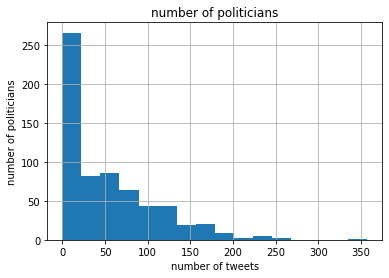

In [124]:
pd.DataFrame(list(n_tweet_dict.values())).hist(bins=16)
plt.title("number of politicians")
plt.ylabel('number of politicians')
plt.xlabel('number of tweets')
plt.show()

The most of the politicians has between 0 and 25 tweets.

#### Twitter text statistics (last 200 tweets for every politician)  (LAU)

Loading the tweets:

In [125]:
with open('tweet_dict_all_v2.data', 'rb') as filehandle:
    tweet_dict_onlytext = pickle.load(filehandle) 

The number of twitter profiles who tweets:

In [126]:
len(list(tweet_dict_onlytext.keys()))

642

The tweets of 642 of the politicians has correctly been collected.

Preparing statistics:

In [127]:
total_n_tweets=0
total_string_length=0

n_tweet_dict=dict()
tweet_lengths_all_dict=dict()
tweet_length_agg_dict=dict()

for pol in list(tweet_dict_onlytext.keys()):
    
    tweet_lengths_all_dict[pol]=[]
    
    n_tweet_dict[pol]=len(tweet_dict_onlytext[pol])
    total_n_tweets+=len(tweet_dict_onlytext[pol])
    
    
    for elems in list(tweet_dict_onlytext[pol]):
        elems_splittet_to_words=elems.split()
        tweet_lengths_all_dict[pol].append(len(elems_splittet_to_words))
        
        total_string_length+=len(elems_splittet_to_words)        
            
    #Save the total amount of characters for each politician
    tweet_length_agg_dict[pol]=sum(tweet_lengths_all_dict[pol])

In [128]:
print("The total number of tweets {}".format(total_n_tweets))

The total number of tweets 83663


In [129]:
print("The average length of tweets {}".format(total_string_length/total_n_tweets))

The average length of tweets 22.032176708939435


Making a histogram over the sum of the length of all tweets for all politicians using Sturge's rule for the number of bins:

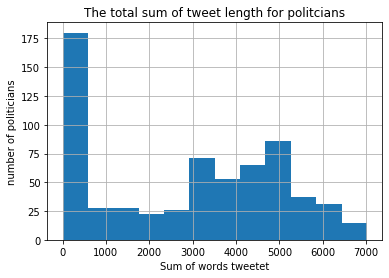

In [130]:
pd.DataFrame(tweet_length_agg_dict.values()).hist(bins=12)
plt.title("The total sum of tweet length for politcians")
plt.ylabel('number of politicians')
plt.xlabel('Sum of words tweetet')
plt.show()

Most of the politicians has a tweetet in total between 0 and 500 words.
Then a "normal"-like distribution occur with min around 2000 and max around 7000. Theres a spike around 5000 words tweetet.

Plot the distribution of the length of the tweets (again using Sturge's rule).

In [131]:
list2d=list(tweet_lengths_all_dict.values())

In [132]:
import itertools
merged = list(itertools.chain(*list2d))

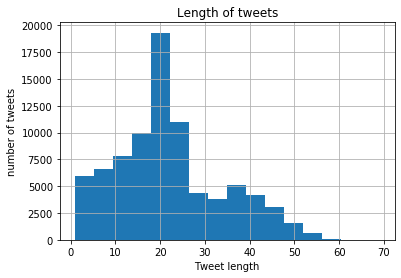

In [133]:
pd.DataFrame(merged).hist(bins=16)
plt.title("Length of tweets")
plt.ylabel('number of tweets')
plt.xlabel('Tweet length')
plt.show()

In [134]:
max(merged)

69

Most of the tweets where is around 20 words long and the distribution-tail flattens out with a maximum at 69 words.

The API has a limit of 200 tweets, but not all politicians neccesarily has tweetet 200 times. 
Plotting the distribution of number of tweets collected.

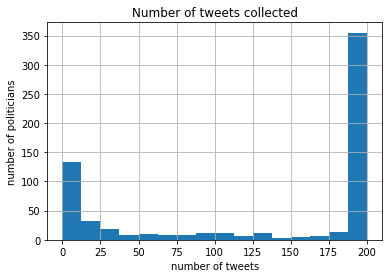

In [135]:
pd.DataFrame(list(n_tweet_dict.values())).hist(bins=16)
plt.title("Number of tweets collected")
plt.ylabel('number of politicians')
plt.xlabel('number of tweets')
plt.show()

In [136]:
np.quantile(list(n_tweet_dict.values()),0.25)

20.25

In [137]:
np.quantile(list(n_tweet_dict.values()),0.5)

199.0

In [138]:
a=np.array(list(n_tweet_dict.values()))

In [139]:
np.count_nonzero(a == 200)

312

25% of the politicians has 20 or less tweets, but over 50% has 200 tweets.
312 politicians have 200 tweets. 

#### Meetings text statistics (FREDERIK)

### Network statistics (LAU) & (CHRISTIAN)

The generation of the network is based on the previous generated dictionary from [Tweets-(who-tags-who)](#Tweets-(who-tags-who)) section. 

In [140]:
with open('tweet_dict_listversion_wrealnames_v2.data', 'rb') as filehandle:
    tweet_dict = pickle.load(filehandle) 

When a politician e.g Lars Løkke, mentions another politicians e.g. Morten Østergaard, the two politicians are connected. Each politician represent a node in the graph. The mentioning using a "@" makes alink from Lars to Morten, which gives a directed edge from Lars to Morten. Morten does not neccesarily mention Lars in any posts - therefore, to incoporate the complexity of mentioning in Twitter, a directed graph is chosen for the social politician Twitter network.

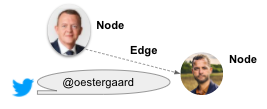

In [141]:
from IPython.display import Image
Image(filename='images/lars_mention_oster.png')

For generating a graph representing the network of twitter politicians, the NetworkX library is used. The library makes it possible to create a empty directed graphs, and one by one add connections (edges) between the politicians. The labels of the nodes are the politicians' twitternames.

Create the directed graph:

In [142]:
G=nx.DiGraph()

Make edge from tweeting politicinas to the ones that they mentions. Before generating the network, it is assumed that if Lars mentions Morten in e.g. 12 tweets, then the edge from Lars to Morten has a weight value of 12.

If Lars then only mentions Margrethe Vestager 3 times, the edge from Lars to Vestager is 3. 

The weight $W_{ij}$ in the graph therefore represent the number of times politician (node) *i* mentions politician (node) *j*.

The weight for a edge is then calculated by finding the length of the list of tweets where politician *i* mentions politician *j*.


In [143]:
for pol in list(tweet_dict.keys()): #All politician, i
    for to_pol in list(tweet_dict[pol].keys()): #All that i mentions, j
            if G.has_edge(pol, to_pol):
                # If there's already a edge, print a error
                print("error")
            else:
                G.add_edge(pol, to_pol, weight=len(tweet_dict[pol][to_pol]))

Save/load file locally:

In [144]:
#nx.write_gpickle(G, "second_network_w_weights_listversion_wrealnames_v2.gpickle")
G = nx.read_gpickle("second_network_w_weights_listversion_wrealnames_v2.gpickle")

Having created the graph, we can now look into the first statistics of the network. 

In [145]:
print("The number of nodes: {}".format(G.number_of_nodes()))
print("The number of edges: {}".format(G.number_of_edges()))

The number of nodes: 561
The number of edges: 10445


Out of the 650 politicians, 561 of them has mentioned another politician or has been mentioned. Between all of the nodes theres 10445 weighted edges.

To get the first glance of the network, networkx is used for plotting the graph. The size of the nodes is in this plot dependent of the degree.  

In [146]:
d = dict(G.degree(G.nodes()))

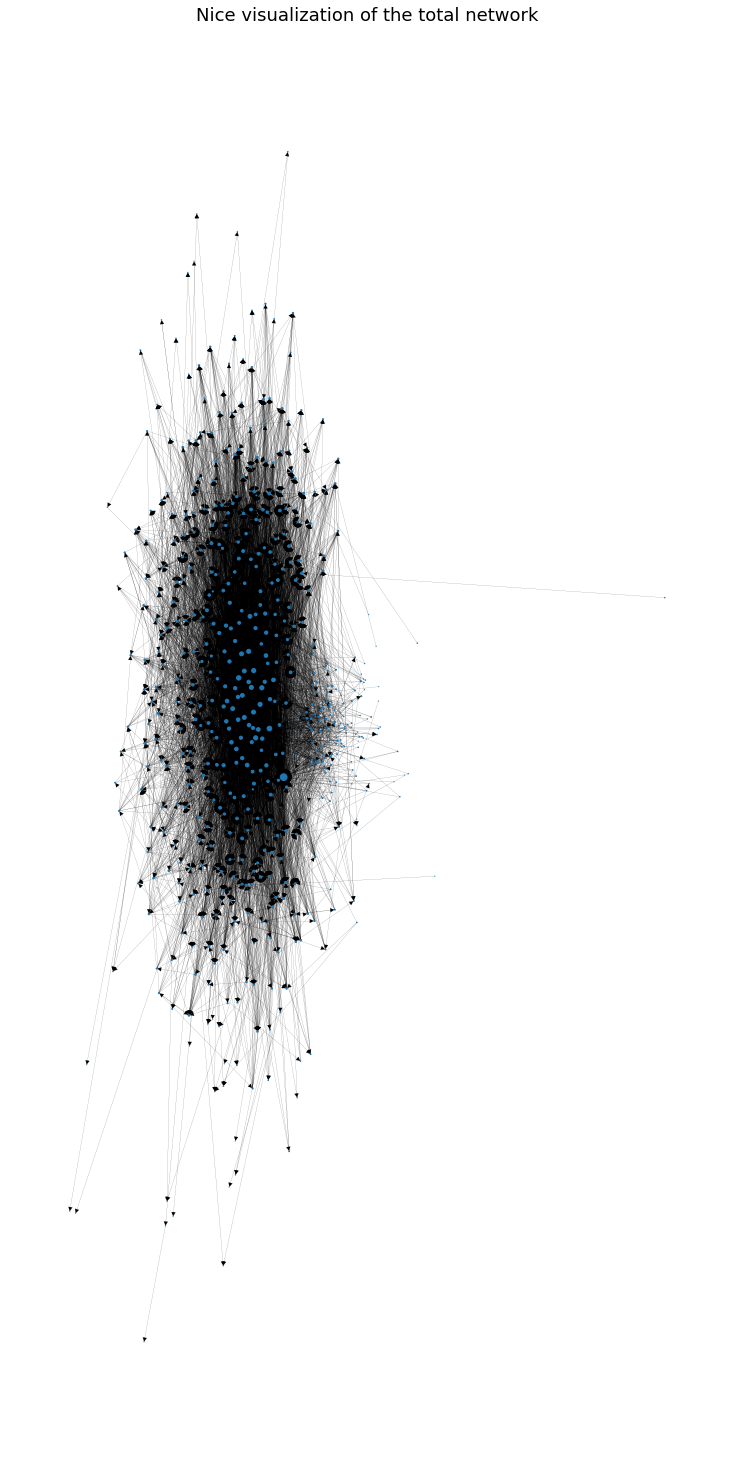

In [147]:
plt.figure(figsize=(10,20))
nx.draw_kamada_kawai(G, node_size=[v * 0.1 for v in d.values()], width=0.1)

plt.title("Nice visualization of the total network",fontsize=18)
plt.show()

Networkx has a tool to give the weighted node degree. From [networkx.DiGraph.degree](https://networkx.org/documentation/stable/reference/classes/generated/networkx.DiGraph.degree.html): "The weighted node degree is the sum of the edge weights for edges incident to that node.". Thereby the degree of a node/Politician depends on the number of Tweets the politician has been mentioned in. If the weight has not been used.

In [148]:
d_weight = dict(G.degree(G.nodes(),'weight'))

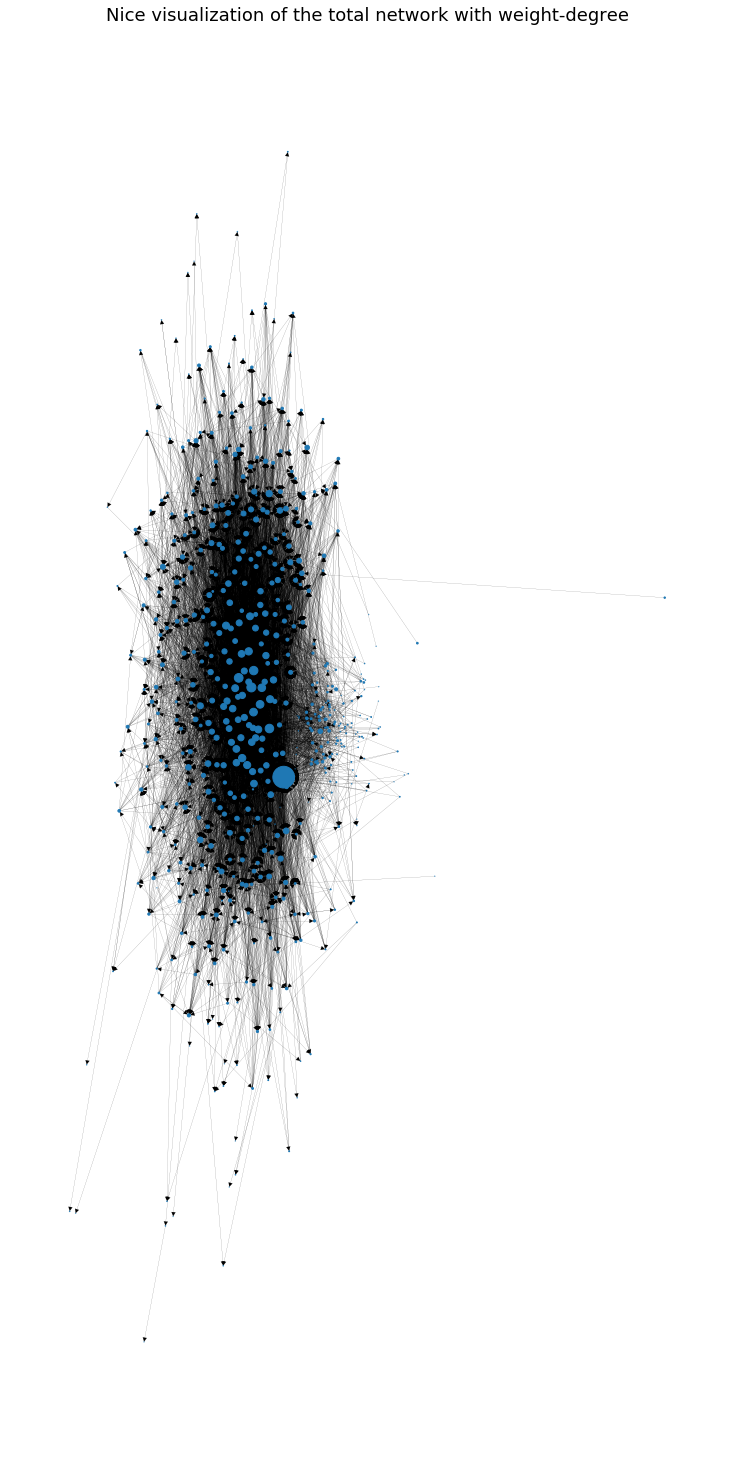

In [149]:
plt.figure(figsize=(10,20))
nx.draw_kamada_kawai(G, node_size=[v * 0.1 for v in d_weight.values()], width=0.1)

plt.title("Nice visualization of the total network with weight-degree",fontsize=18)
plt.show()

The use of weighted degree has a clear impact on the graph. Looking at Vestager again, the degree value increases by around 85%.

In [150]:
def get_change(current, previous):
    if current == previous:
        return 100.0
    try:
        return (abs(current - previous) / previous) * 100.0
    except ZeroDivisionError:
        return 0

In [151]:
start=list(dict(G.degree(["vestager"])).values())[0]
print(start)

48


In [152]:
end=list(dict(G.degree(["vestager"],'weight')).values())[0]
print(end)

89


In [153]:
get_change(end,start)

85.41666666666666

Vestager's node in_degree difference between a non-weighted and a weighted is 85.4%. Finding all the difference between all politicians degree and weighted degree:

In [154]:
deg_deff_dict={}
for node in list(G.nodes()):
    start=list(dict(G.degree([node])).values())[0]
    end=list(dict(G.degree([node],'weight')).values())[0]
    deg_deff_dict.update({node:get_change(end,start)})

Looking at the highest differences:

In [155]:
sorted(deg_deff_dict.items(), key=lambda x: x[1], reverse=True)[0:5]

[('Forsvarsmin', 1150.0),
 ('HolmerHans', 1128.5714285714287),
 ('regeringDK', 933.6263736263737),
 ('MortenSkovlund', 833.3333333333334),
 ('LiselotteLyngeJ', 804.3478260869565)]

In [156]:
print("regeringDK degree: {}".format(G.degree("regeringDK")))
print("HolmerHans degree: {}".format(G.degree("HolmerHans")))

regeringDK degree: 455
HolmerHans degree: 7


In [157]:
print("regeringDK degree: {}".format(G.degree("regeringDK",'weight')))
print("HolmerHans degree: {}".format(G.degree("HolmerHans",'weight')))

regeringDK degree: 4703
HolmerHans degree: 86


The danish parliament has its own twitterprofile, which apparently has a lot of mentions. With a degree of 455 it implicates that the profile is very connected. But including the weight it is even more obvoius that alot of tweets from a lot of politicians mentions "regeringDK"

HolmerHans is Chairman of Social and Health at Kolding City Council. Using only the non-weighted degree, the importance of this twitterprofile could might be underestimated. When accounting for the number of tweets (weight) he suddenly become very actively in the social twitter network.

### Adding node attributes

We want to add some metadata to this twitter network. Of course, this meta data will be the parties of these politicians, but since we can, also the regions that they belong to.

In [172]:
# defining a function that ensures G and dataframe are equal sizewise

G = nx.read_gpickle("second_network_w_weights_listversion_wrealnames_v2.gpickle")
def pre_check():
    nodes = G.nodes()
    count=0
    to_remove = [] 
    for node in nodes:
        if node in data.values:
            count+=1
        else:
            print(node + " will be removed")
            to_remove.append(node)
    for node in to_remove:
        G.remove_node(node)
    return len(to_remove)

print("Removing " +str(pre_check()) + " nodes")

Birgitte2012 will be removed
MFVMin will be removed
SassLarsen will be removed
AsgerChristens2 will be removed
Martin_geertsen will be removed
Removing 5 nodes


In [177]:
# Next we make a dict of attributes of "party" and "region" are these attributes

dict_of_attributes = {}
for node in G.nodes():
    #print(node)
    x = data.loc[data['Twittername'] == node]
    #print(x)
    party =  x.values[0][2]
    region = x.values[0][3]
    #print(node, party, region)
    attribute = {'party': party, 'region': region}
    dict_of_attributes[node] = attribute
nx.set_node_attributes(G, dict_of_attributes)



**Counting links between parties**

In [178]:
parties = list(nx.get_node_attributes(G,'party').values())
politicians=list(G.nodes)
unique_parties = set(parties)

tweet_to_count = {}
tweet_out_count = {}

for party in unique_parties:
    tweet_to_count[party] = 0
    tweet_out_count[party] = 0
    
# party in + out degrees
print("edges (mentions): " + str(G.number_of_edges()))
for edge in G.edges():
    _from = edge[0]
    _to = edge[1]
    _to_party = parties[politicians.index(_to)]
    _out_party = parties[politicians.index(_from)]
    
    
    tweet_to_count[_to_party] += 1
    tweet_out_count[_out_party] += 1

    
tweet_to_count = dict(sorted(tweet_to_count.items(), key=lambda item: item[1], reverse=True))
tweet_out_count = dict(sorted(tweet_out_count.items(), key=lambda item: item[1],reverse=True))


edges (mentions): 10263


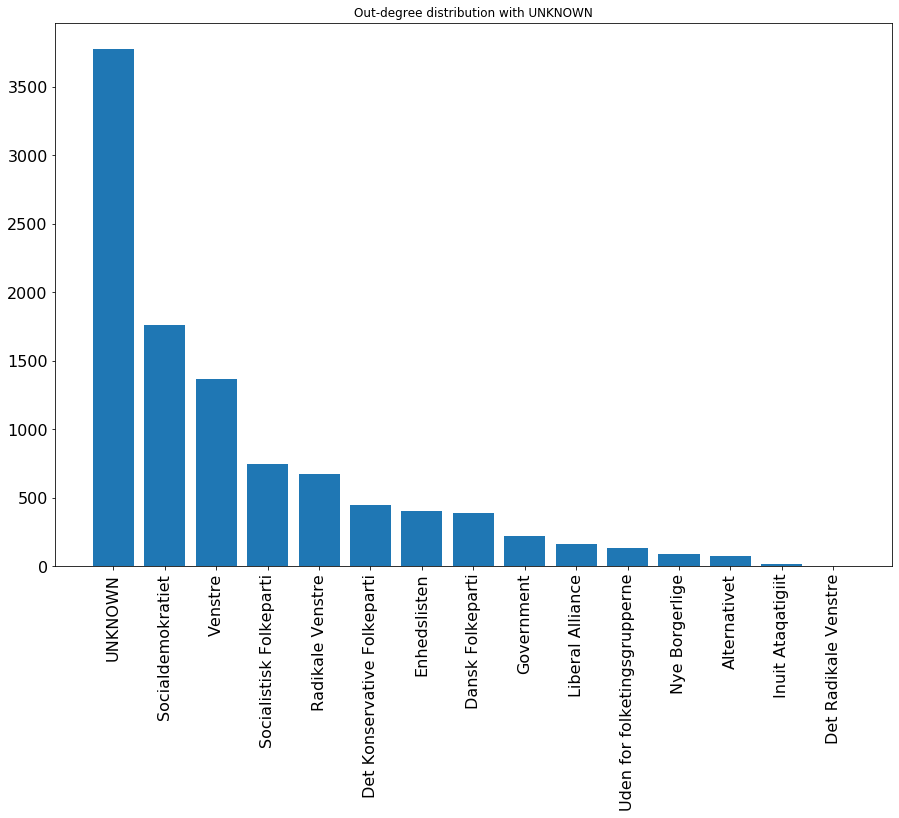

In [179]:
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.subplots(figsize=(15,10))

plt.tick_params(labelsize=16)
plt.xticks(rotation=90)
plt.bar(tweet_out_count.keys(), tweet_out_count.values())
plt.title("Out-degree distribution with UNKNOWN")
plt.show()

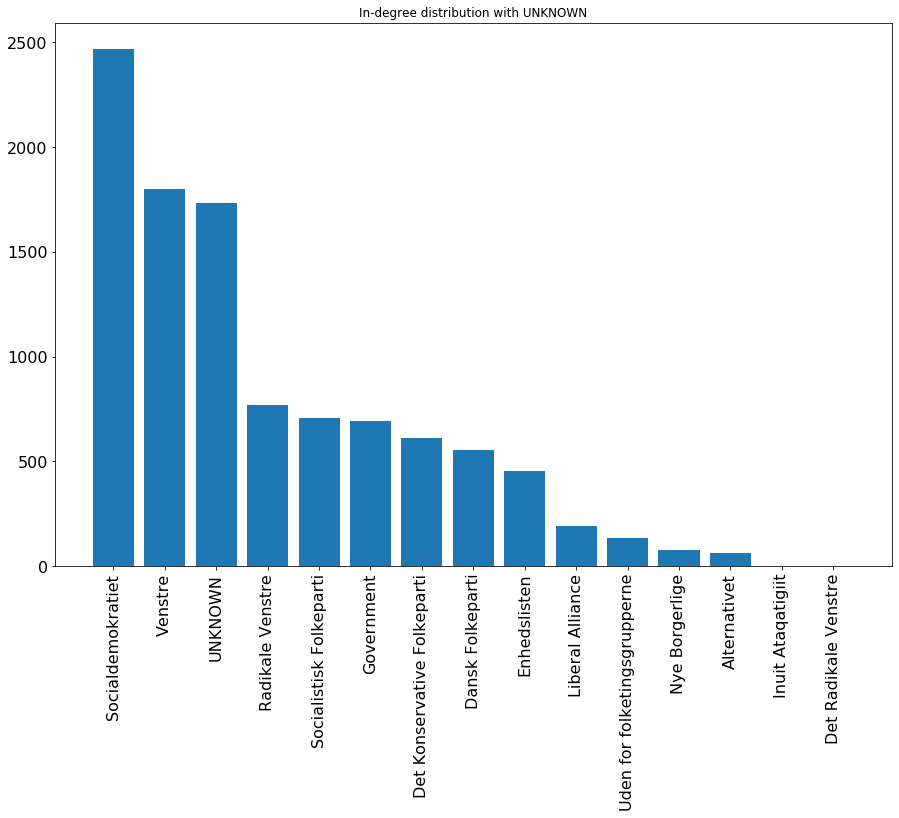

In [181]:
fig = plt.subplots(figsize=(15,10))

plt.tick_params(labelsize=16)
plt.xticks(rotation=90)
plt.bar(tweet_to_count.keys(), tweet_to_count.values())
plt.title("In-degree distribution with UNKNOWN")
plt.show()

**Without the unknowns** 


We want to see it without unknowns in the network and also the mean per person, as it's a bit skewed towards the parties that have the most politicians (more politicians = more tweets)



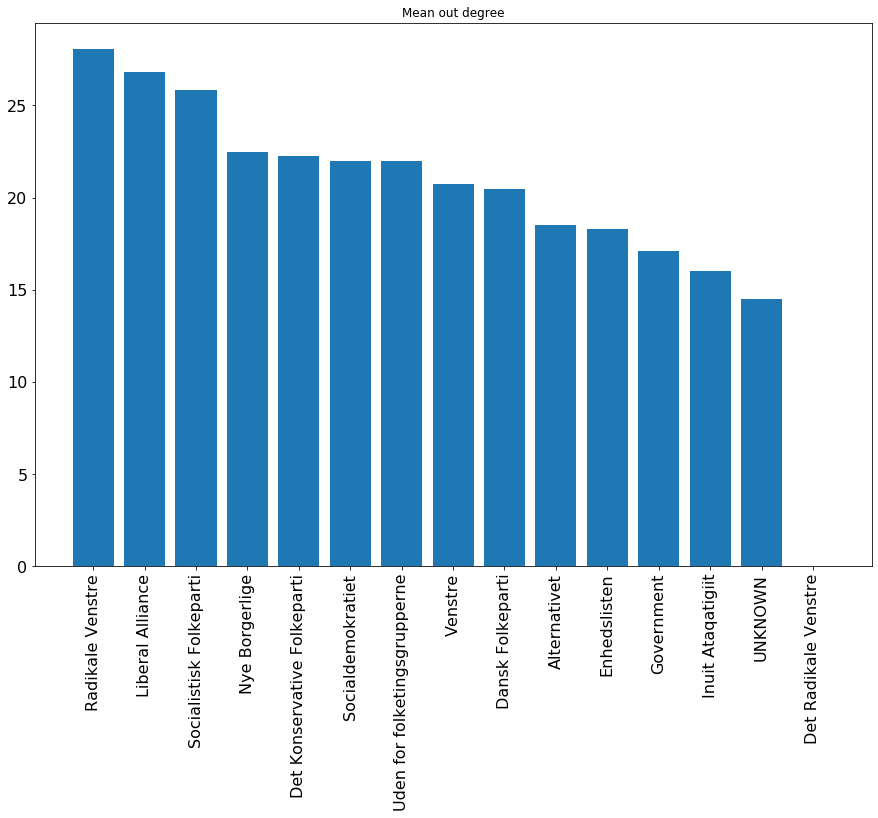

In [182]:

tweet_to_count_clean = tweet_to_count.copy()
tweet_out_count_clean = tweet_out_count.copy()

tweet_to_count_clean.pop('UNKNOWN')
tweet_out_count_clean.pop('UNKNOWN')

vals = nx.get_node_attributes(G, "party").values()
sum_party =dict.fromkeys(tweet_out_count.keys(),0)
for party_occ in vals:
    sum_party[party_occ] += 1
sum_party

avg_tweet_out = dict.fromkeys(tweet_out_count.keys())
avg_tweet_in= dict.fromkeys(tweet_to_count.keys())

for key in tweet_out_count:
    avg_tweet_out[key] = tweet_out_count[key] / sum_party[key]
    avg_tweet_in[key] = tweet_to_count[key] / sum_party[key]
    
ang_tweet_out = dict(sorted(avg_tweet_out.items(), key=lambda item: item[1],reverse=True))
avg_tweet_in = dict(sorted(avg_tweet_in.items(), key=lambda item: item[1],reverse=True))


#ax = plt.subplot(111)

#x = pd.DataFrame([avg_tweet_in])
#chart =sns.barplot(x="day", y="total_bill",data=x)
#chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
#plt.show()
fig = plt.subplots(figsize=(15,10))

plt.tick_params(labelsize=16)
plt.xticks(rotation=90)
plt.bar(ang_tweet_out.keys(), ang_tweet_out.values())
plt.title("Mean out degree")
plt.show()

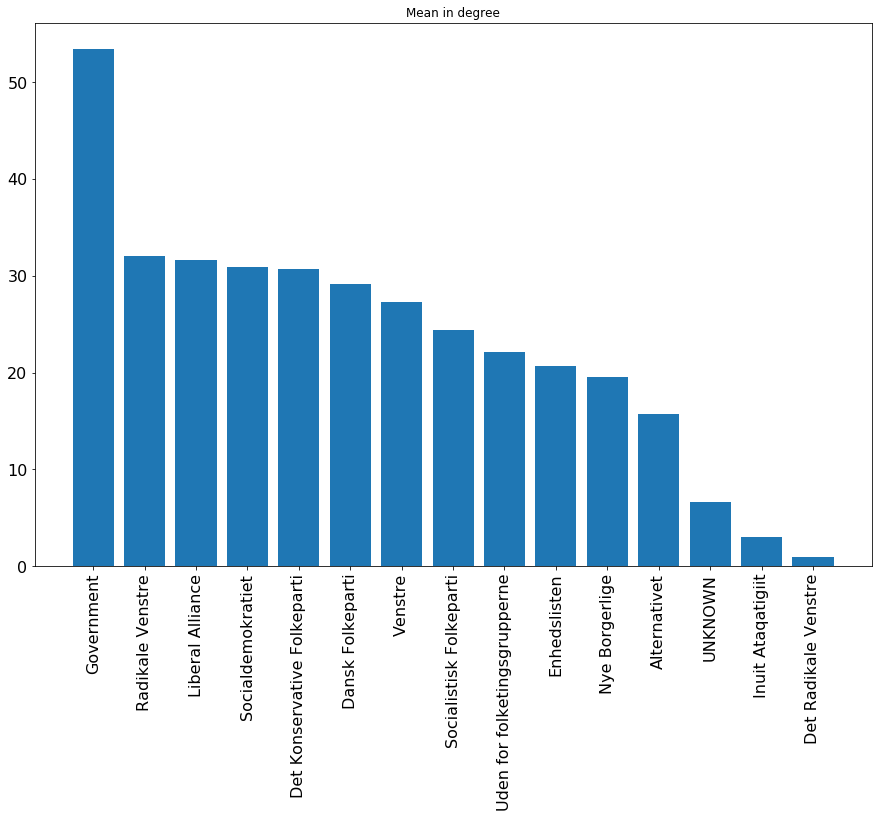

In [183]:
fig = plt.subplots(figsize=(15,10))

plt.tick_params(labelsize=16)
plt.xticks(rotation=90)
plt.bar(avg_tweet_in.keys(), avg_tweet_in.values())
plt.title("Mean in degree")
plt.show()

Lets see how it looks with all the parties added in

100%|██████████| 2000/2000 [00:21<00:00, 94.78it/s]


BarnesHut Approximation  took  2.18  seconds
Repulsion forces  took  17.89  seconds
Gravitational forces  took  0.03  seconds
Attraction forces  took  0.24  seconds
AdjustSpeedAndApplyForces step  took  0.40  seconds


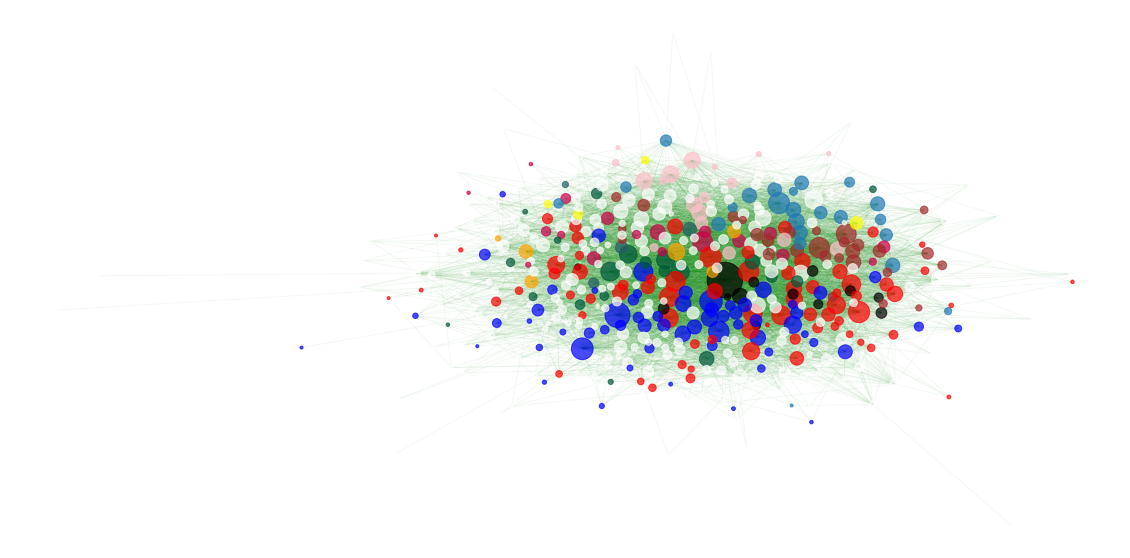

In [184]:
Gcc = sorted(nx.weakly_connected_components(G), key=len, reverse=True)

giant = G.subgraph(Gcc[0])
giant = giant.to_undirected()

for node in list(giant.nodes()):
    if (giant.degree(node) <= 2):
        giant.remove_node(node)

parties = list(nx.get_node_attributes(giant,'party').values())
color_map = []
d = dict(giant.degree) #degrees for every node

#Making color list
for i in range(len(parties)): #for all nodes
    if parties[i] == 'Socialdemokratiet':
        color_map.append('red')
    elif parties[i] == 'Venstre':
        color_map.append('blue')
    elif parties[i]=='Dansk Folkeparti':
        color_map.append('pink')
    elif parties[i]=='Socialistisk Folkeparti':
        color_map.append('brown')
        
    elif parties[i] == 'Radikale Venstre':
        color_map.append('#1f78b4')
        
    elif parties[i] == 'Enhedslisten':
        color_map.append('#D0004D')
        
    elif parties[i] == 'Det Konservative Folkeparti':
        color_map.append('#00583C')
    elif parties[i] == 'Nye Borgerlige':
        color_map.append('#235d66')
    elif parties[i] == 'Liberal Alliance':
        color_map.append('orange')
    elif parties[i] == 'Alternativet':
        color_map.append('yellow')
    elif parties[i] == 'Government':
        color_map.append('black')
    else:
        color_map.append('white')
        
from fa2 import ForceAtlas2

forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs   #Want hubs inside other!
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=True,
                        gravity=1.0,

                        # Log
                        verbose=True)


positions = forceatlas2.forceatlas2_networkx_layout(giant, pos=None, iterations=2000)

plt.figure(figsize=(20,10))
nx.draw_networkx_nodes(giant, positions, node_color=color_map, alpha=0.7,node_size=[v * 3 for v in d.values()])
nx.draw_networkx_edges(giant, positions, edge_color="green", alpha=0.05)
plt.axis('off')
plt.show()

**Observations**

The graph is quite compact, with many large blue and red nodes which makes sense, as these are the biggest parties in denmark; namely "Venstre" and "Socialdemokratiet". Furthermore, there are large black nodes that are central in the network - this also makes sense as we've marked government entities as black. However there are still some problems with the visualization that we want to solve.


**Segregating into red and blue blocks**

The problem with the network visualization is that we have too many different parties and getting a nice visualization becomes difficult. Bloc politics refers to the act of parties uniting in order to gain a majority vote over the parliament. In danish politics, according to https://da.wikipedia.org/wiki/Blokpolitik we have 3 blocs, red blue and green. We will segregate our parties into this by adding a graph attribute "bloc" . Furthermore we will eliminate the unknowns to get a graph that's more manageable.

100%|██████████| 2000/2000 [00:06<00:00, 292.66it/s]


BarnesHut Approximation  took  0.83  seconds
Repulsion forces  took  5.56  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.11  seconds
AdjustSpeedAndApplyForces step  took  0.17  seconds


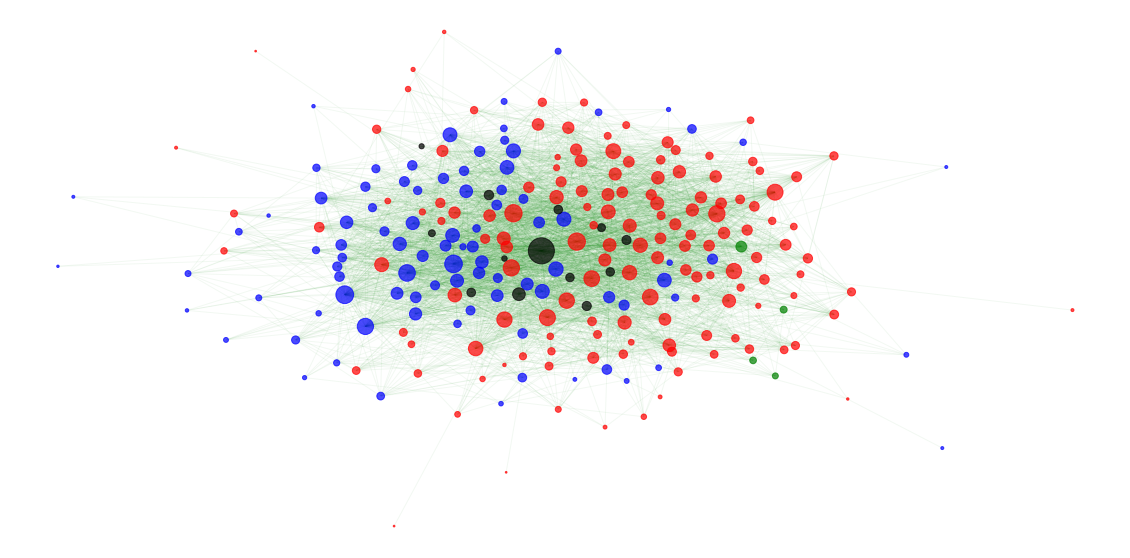

In [185]:
red_bloc = ['Socialdemokratiet', 'Enhedslisten', 'Socialistisk Folkeparti', 'Radikale Venstre']
blue_bloc = ['Venstre', 'Dansk Folkeparty', 'Det Konservative Folkeparti', 'Liberal Alliance', 'Nye Borgerlige', 'Fremad']
green_bloc = ['Alternativet']
    
    
for key, val in dict_of_attributes.items():
    #print(key)
    if val['party'] in red_bloc:
        val['block'] = 'red'
    elif val['party'] in blue_bloc:
        val['block'] = 'blue'
    elif val['party'] in green_bloc:
        val['block'] = 'green'
    elif val['party'] == 'Government':
        val['block'] = 'black'
    else: 
        val['block'] = 'white' # white node means unknown
        
nx.set_node_attributes(G, dict_of_attributes)

Gcc = sorted(nx.weakly_connected_components(G), key=len, reverse=True)

giant = G.subgraph(Gcc[0])
giant = giant.to_undirected()
d = dict(giant.degree) #degrees for every node

for node in list(giant.nodes()):
    if (giant.degree(node) <= 2):
        giant.remove_node(node)

block_color_map = list(nx.get_node_attributes(giant, 'block').values())

# removing the unknowns
for node in list(giant.nodes(data=True)):
    if (node[1]['block'] == 'white'):
        giant.remove_node(node[0])
block_color_map = list(nx.get_node_attributes(giant, 'block').values())
d = dict(giant.degree) #degrees for every node

forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs   #Want hubs inside other!
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=True,
                        gravity=1.0,

                        # Log
                        verbose=True)


positions = forceatlas2.forceatlas2_networkx_layout(giant, pos=None, iterations=2000)

plt.figure(figsize=(20,10))
nx.draw_networkx_nodes(giant, positions, node_color=block_color_map, alpha=0.7,node_size=[v * 3 for v in d.values()])
nx.draw_networkx_edges(giant, positions, edge_color="green", alpha=0.05)
plt.axis('off')
plt.show()

G = nx.read_gpickle("second_network_w_weights_listversion_wrealnames_v2.gpickle")

The network looks a bit neater, but we can observe that the large central government profiles have decreased in degree, signalling that a lot of the unknowns have tweeted to that profile. Interestingly, the few green block nodes are leaning to the right. Now we will look at sentiment of tweets, that link 2 profiles.

**Conclusion:**

With 561 danish politicians, connected by 10445 edges a directed graph representing a "Social network of danish politicians on Twitter" has been created. The graph is directed do to the distinction between politician A mentioning politician B, and the other way around. Using a weighted directed graph emphasizes the importance on the number of tweets on Twitter. 

# Tools, theory and analysis

## Overall idea

## Analysis step 1: Network  (LAU)

This project aims to build models that reproduce the properties of real networks. To examine whether the graph reproduces a real network or it is just a random network, the degree distribution of a random network is compared to the Twitter network. 

By examining the properties of the Twitter network, there can be shed light on how politicians can influence each other. This project assumes, that a politician is interested to know how to influence others most effectively and how to spred a message to the public including the other politicians. 

In the following section degree-distributions are going to be plotted. For this purpose the code below can plot a customade histogram. For plotting an appropiate amount of bins [Sturge's formula](https://en.wikipedia.org/wiki/Histogram#Sturges'_formula) is applied. The number of bins is equal to $\lceil log_{n}\rceil +1$, where *n* is the total number of observations.

In [13]:
def custom_histogram(list_of_values,title_name,x_label,y_label):
    
    #Sturges rule for number of bins
    n_bin=math.ceil(math.log2(len(list_of_values)))+1
    
    hist,bin_edges=np.histogram(list_of_values,bins=n_bin)

    rightboundary=bin_edges[1:]
    leftboundary=bin_edges[:-1]
    newlist_in=[] # list with leftboundary1,rightboundary1,leftboundary2,rightboundary2
    newvalues_in=[] # histvalue1,histvalue1,histvalue2,histvalue2,....
    for i in range(len(rightboundary)):
        newlist_in.append(leftboundary[i])
        newvalues_in.append(hist[i])
        newlist_in.append(rightboundary[i])
        newvalues_in.append(hist[i]) 
    points_in=zip(newlist_in,newvalues_in)


    plt.figure(figsize=(8,8))
    plt.plot(newlist_in,newvalues_in,color='#0504aa')
    for pt in points_in:
        plt.plot( [pt[0],pt[0]], [0,pt[1]],color="#0504aa" )

    plt.title(title_name,fontsize=18)
    plt.xlabel(x_label,fontsize=14)
    plt.ylabel(y_label,fontsize=14)
    plt.show()

Next, the in- and out-degree of the graph is assesed. This is done in order to get an idea of how the politicians are connected.

In [ ]:
list_in=list(dict(G.in_degree()).values()) # This is all of the nodes' degrees
list_out=list(dict(G.out_degree()).values()) # This is all of the nodes' degrees

In [ ]:
custom_histogram(list_in,"Binning in-degree distribution","in-degree","Frequency")
custom_histogram(list_out,"Binning out-degree distribution","out-degree","Frequency")

From [Network Sciencebook - Chapter 3, sec. 3.2](http://networksciencebook.com/chapter/3):
"A random network consists of N nodes where each node pair is connected with probability p."

To calculate the probability p of the Politician Twitter Network, the average degree, k, is found. From [Network Sciencebook - Chapter 3, sec. 3.3](http://networksciencebook.com/chapter/3#random-network) eq. 3.3 the following holds:

$k = p ( N-1)$

so $p = \frac{k}{N-1}$

Since *k* is equal to the average degree, networkx can calculate the value:

In [ ]:
k=np.mean(list(dict(G.degree()).values())) 
print(k)



###Should we use the weighted???

#k=np.mean(list(dict(G.degree(G.nodes(),'weight')).values())) 
#print(k)

The number of nodes:

In [ ]:
N=G.number_of_nodes()

The probability of each pair of nodes is connected:

In [ ]:
p=k/(N-1)
print(p)

Generating the random graph from extracted parameters

In [ ]:
G_ER=nx.erdos_renyi_graph(N,p,directed=True) 

Plotting the degree distribution for the ER graph.

In [ ]:
list_in_r=list(dict(G_ER.in_degree()).values()) # This is all of the nodes' degrees
list_out_r=list(dict(G_ER.out_degree()).values()) # This is all of the nodes' degrees

In [ ]:
custom_histogram(list_in_r,"Binning in-degree distribution for random graph","in-degree","Frequency")
custom_histogram(list_out_r,"Binning out-degree distribution for random graph","out-degree","Frequency")

**Conclusion:**

Comparing the distribution of the twitter network and a random graph, it can be concluded, that there a difference in the degree distribution. 

The twitter network is in-degree distribution is more right skewed than the random network. 
Even though, the twitter network out-degree has a more normal-like distribution strucutre, there's still a big spike at out-degree between 0 and 5.  

### Using the giant component

The generated network should be representing the Danish Politicians Twitter network - therefore, it should not be "just" a random graph. 

The main difference between a random graph and a scale-free network, is the HUBS. According to [Network Science Book - section 5.2](http://networksciencebook.com/chapter/5) new nodes in most real networks prefers tolink to the more conencted node. This process is "preferential attachment" Preferential attachment and growth, are the two properties of the emerging of scale-free network. Scale-free networks are networks, which degree distribution is different than the degree distribution of a random network.

The probability of two nodes linking, influence the structure of the graph. There are two extreme cases. If p=0, there's zero probability that any node link to another - all nodes are isolated. If p=1, there's 100% probability that any node link to another - the graph is complete, all nodes links to each other. To get insight into how the politcian Twitter network strucures itself and why, the folllowing analysis will examine the link-probability and number of nodes. Once the average node degree exceeds a critical value, the rapid emergence of a large cluster that we call the giant component occurs. 

There are four different topological distinct regimes according to [Network Science Book - section 3.6](http://networksciencebook.com/chapter/3#evolution-network). One can distinguish between them by looking at their characteristics - more specifically on the relation between p and N. 

In [ ]:
print(p >math.log(N)/N)

The regime is a connected regime , because p>ln(N)/N. This indicates that the twitter network will emerge to a giant component, which aborbs all nodes and components. 

According to [Network Science Book - section 3.7](http://networksciencebook.com/chapter/3#networks-supercritical) most networks are supercritical. But e.g. the real network of Actors is in the connected regime. The twitter network of politicians properties are therefore consistent with the some of the properties of other real world networks. 

The critical point seperates the regime where theres is a giant component from the one wheres there's not.
For the network to be at a critical point k, the average node degree, must be equal to 1. This also means that pc=1/N.

In [ ]:
pc=1/(N-1) 
print("{:.4f}".format(pc))

The linking probability for the twitter network must be 2% for the network to be at the critical point. If the the probability is 2% or lower, all of the politicians are connected in small components. In the aspect of the influence of politics, the twitter network will then become much more "useless" for a politician if the linking probability was lower. To get further analyze the giant component of the twitter network, the giant component can be extracted using networkx.

The algorithm for finding the giant component (and also later using forceatlas to make nice visualizations) needs the graph to be undirected.

In [ ]:
G_undirected=G.to_undirected()

Extract the giant component.

In [ ]:
Gcc = sorted(nx.weakly_connected_components(G), key=len, reverse=True)
giant_directed=G.subgraph(Gcc[0])
giant = G_undirected.subgraph(Gcc[0])
d = dict(giant.degree) #Saves the degree for making the nodesize depended of the degreee in plots

In [ ]:
print("The number of nodes: {}".format(giant_directed.number_of_nodes()))
print("The number of edges: {}".format(giant_directed.number_of_edges()))

The giant component contained 555 politicians out of 561. This shows how almost all politicians are absorbed in the giant component. Below is a visualization of the component.

In [ ]:
from fa2 import ForceAtlas2

forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs   #Want hubs inside other!
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=False,
                        gravity=1.0,

                        # Log
                        verbose=True)


positions = forceatlas2.forceatlas2_networkx_layout(giant, pos=None, iterations=2000)

In [ ]:
plt.figure(figsize=(20,10))
nx.draw_networkx_nodes(giant, positions, alpha=0.4,node_size=[v * 1 for v in d.values()])
nx.draw_networkx_edges(giant, positions, edge_color="green", alpha=0.05)
plt.axis('off')
plt.show()

In [ ]:
#list_in=list(dict(giant_directed.in_degree()).values()) # This is all of the nodes' degrees
#list_out=list(dict(giant_directed.out_degree()).values()) # This is all of the nodes' degrees

In [ ]:
#custom_histogram(list_in,"Binning in-degree distribution for giant component","in-degree","Frequency")

In [ ]:
#custom_histogram(list_out,"Binning out-degree distribution for giant component","out-degree","Frequency")

According to [Network Science Book - section 4.2](http://networksciencebook.com/chapter/4) the degrees of a random network follows a possion distribution. Therefore, a random network is generated, and the distribution of the degrees can be compared in a normal scale and log-log scale.

Generating the random graph by initially finding N and p for the graph:

In [ ]:
k_giant=np.mean(list(dict(giant.degree()).values())) 
print(k_giant)

The number of nodes:

In [ ]:
N_giant=giant.number_of_nodes()

The probability of each pair of nodes is connected:

In [ ]:
p_giant=k_giant/(N_giant-1)
print(p_giant)

Generating the random graph from extracted parameters.

In [ ]:
G_r = nx.generators.fast_gnp_random_graph(N_giant,p_giant)

degree_freq_r = nx.degree_histogram(G_r)
degrees_r = range(len(degree_freq_r))

Plotting the random graph degree distribution and the giant component graphs degree.

In [ ]:


fig, axs = plt.subplots(2,figsize=(13,13))
fig.suptitle('Degree distribution of network',size=25)
m=1

degree_freq = nx.degree_histogram(giant)
degrees = range(len(degree_freq))

#####PLOT 1##########
axs[0].plot(degrees[m:], degree_freq[m:],'go')
axs[0].plot(degrees_r[m:], degree_freq_r[m:],'bo-')
green1_patch = mpatches.Patch(color='g', label='Degrees of giant component')
blue1_patch = mpatches.Patch(color='b', label='Degrees of random network')
axs[0].legend(handles=[blue1_patch,green1_patch])


###PLOT 2 ######
axs[1].loglog(degrees[m:], degree_freq[m:],'go')
axs[1].loglog(degrees_r[m:], degree_freq_r[m:],'bo-')
green2_patch = mpatches.Patch(color='g', label='Degrees of giant component')
axs[1].legend(handles=[green2_patch])
blue2_patch = mpatches.Patch(color='b', label='Degrees of random network')
axs[1].legend(handles=[blue2_patch,green2_patch])



axs[0].set_ylabel('Number of nodes',fontsize = 14)
axs[1].set_xlabel('k',fontsize = 14)
axs[1].set_ylabel('Number of nodes',fontsize = 14)

plt.subplots_adjust(hspace=0.1)

**Conclusion:**
To yet examine the randomness, the above plots can be inspected. On the log-log plot, the degree distribution of the giant component, the power law follows a approximately straight line. The giant component of the twitter network, is therefore different from the poisson distribution (random network). Since the Twitter network follows the power-law, is is therefore according to [Network Science Book - section 4.2](http://networksciencebook.com/chapter/4) a **scale-free network**. 


A property of a scale-free network, is the nature of preferential attachment. This affects the degree of the largest node, so new politicians joining danish politics (and Twitter) will prefer to connect to some of the hubs in the network. One or few large hubs connects to most of the notes, which can represent some of the most influental twitter-profiles. Or, at least be a great potential source of bringing a message. The graph is in the connecte regime, and the giant component of the twitter network absorbs all nodes. Therefore, all politicians are somehow connected in the twitter network - the next question is then: "How are they connected?" "Who should a politician address in order to cement a polical agenda?"


### HOUSE OF CARDS - The danish version

"Who should a politician address in order to cement a polical agenda?" This question reminds one of the plot from [House of Cards](https://en.wikipedia.org/wiki/House_of_Cards_(American_TV_series)):


"*Congressman Frank Underwood (Kevin Spacey), a Democrat from South Carolina's 5th congressional district and House Majority Whip, and his equally ambitious wife Claire Underwood (Robin Wright). Frank is passed over for appointment as Secretary of State, so he initiates an elaborate plan to attain power, aided by Claire. The series deals with themes of ruthless pragmatism, manipulation, betrayal, and power.*"

This story is possibly more dramatized than the real life of danish politicians. Nevertheless, this case is called "House of Cards - the danish version". If a few politicians on twitter connects to many others, then these could potentially have a great influence on formation of the public opinion - and maybe also the opinion of other politicians.

If a politician should indirectly address a person through twitter, by talking to a person who knows a person who knows a person..., it is interesting to know what the greatest distance in the network is. This is the same as the diameter of the graph. 

In [ ]:
nx.diameter(giant)

Between any two politicians, the maximum number of people connecting the two, is 6. This number is actually quite interesting, because [Network Science Book - section 3.8](http://networksciencebook.com/chapter/3#small-worlds) describes the "Small World Phenomenon": that two individuals anywhere on Earth, you will find a path of at most six acquaintances between them. The twitter network giant has only 555 nodes, so the distance between any two nodes should probably be less than 6. [Network Science Book - section 3.8](http://networksciencebook.com/chapter/3#small-worlds)  states that:

< k > nodes should be at distance one

$< k >^{2}$ nodes should be at distance two

$< k >^{3}$ nodes should be at distance three...

where < k > is the average degree.

In [ ]:
print("<k>: {}".format(k_giant))
print("<k>^2: {}".format(math.pow(k_giant,2)))

This means, that almost all politicians should be in a distance of 2 from eachtoher. The average shortest path can shed more light on this:

In [ ]:
nx.average_shortest_path_length(giant)
#nx.average_shortest_path_length(giant_directed)

As expected, the average shortest path between two politicians in the twitter network is approx. 2. 

The average shortest path of the twitter network confirms, that small world phenomeom holds for the Danish Twitter Network. The following demonstration shows how a random politician are (almost) 2 nodes away from all other.

This code can generate a plot for finding and visualizing nodes that are *d* nodes away from a node:

In [ ]:
def plot_d_step_away(node_name,graph,d,color_for_nodes,plotting="yes"):
    #Saves the shortest path
    values=np.array(list(nx.single_source_shortest_path_length(giant,node_name).values()))
    nodess=np.array(list(nx.single_source_shortest_path_length(giant,node_name).keys())) 
    
    #Making a bool-list which detects if the path (or steps) are equal to d:
    steps2= [True if element==d else False for element in values]
    
    #The bool-list can then select the nodes which are d steps away:
    
    nodes2=nodess[steps2]
    
    dic=nx.single_source_shortest_path_length(giant,node_name)
    
    
    
    color_map = []
    alpha_list=[]
    for node in giant:
        if node == node_name:
            color_map.append('green')
            alpha_list.append(1)
        elif node in nodes2:
            color_map.append(color_for_nodes)
            #alpha_list.append(dic[node]*0.5)
            alpha_list.append(1)
        else: 
            color_map.append('grey')  
            alpha_list.append(dic[node]*0.2)
            
    if plotting=="yes":
        plt.figure(figsize=(10,20))
        nx.draw_kamada_kawai(giant,node_size=50, node_color=color_map)
        plt.title("GCC (Green random node with "+color_for_nodes +"coloured nodes "+str(d)+" steps away",fontsize=18)
        plt.show()
    
    return color_map,alpha_list

    
    

Choosing a random politician:

In [ ]:
import random
#rc=random.choice(list(giant.nodes()))
rc="StemClausson"

In [ ]:
print(rc)

Create forceatlas positions for the giant connected component.

In [ ]:


forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs   #Want hubs inside other!
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=False,
                        gravity=1.0,

                        # Log
                        verbose=True)


positions = forceatlas2.forceatlas2_networkx_layout(giant, pos=None, iterations=2000)

Finding the nodes that are 1,2,3,4,5,6 nodes away :

In [ ]:
c_map,alpha_list=plot_d_step_away(rc,giant,1,"red",plotting="no")
c_map2,alpha_list2=plot_d_step_away(rc,giant,2,"blue",plotting="no")
c_map3,alpha_list3=plot_d_step_away(rc,giant,3,"purple",plotting="no")
c_map4,alpha_list4=plot_d_step_away(rc,giant,4,"orange",plotting="no")
c_map5,alpha_list5=plot_d_step_away(rc,giant,5,"magenta",plotting="no")
c_map6,alpha_list6=plot_d_step_away(rc,giant,6,"cyan",plotting="no")

#Saves all list together:
c_map_all=[c_map,c_map2,c_map3,c_map4,c_map5,c_map6]
alpha_list_all=[alpha_list,alpha_list2,alpha_list3,alpha_list4,alpha_list5,alpha_list6]

Make StemClaussons node bigger than the others.

In [ ]:
n_sizes = [50 if node!='StemClausson' else 450 for node in list(giant.nodes())   ]

To make a nice GIF for the website, the nodes that are 1-4 steps away from StemClausson is generated (no are more than 4). Then they are uploaded to https://ezgif.com/maker, which genrates the GIF.

In [ ]:
for i in range(4):
    plt.figure(figsize=(20,10))
    
    #Draw the graph
    nx.draw_networkx_nodes(giant, positions,node_color=c_map_all[i],node_size=n_sizes)
    nx.draw_networkx_edges(giant, positions, edge_color="grey", alpha=0.1)

    #Legends
    patch1 = Line2D([0], [0], marker='o', color='w', label='1 step away',
                        markerfacecolor='r',markersize=20)
    patch2 = Line2D([0], [0], marker='o', color='w', label='2 step away',
                        markerfacecolor='b',markersize=20)
    patch3 = Line2D([0], [0], marker='o', color='w', label='3 step away',
                        markerfacecolor='purple',markersize=20)
    patch4 = Line2D([0], [0], marker='o', color='w', label='4 step away',
                        markerfacecolor='orange',markersize=20)
    patch5 = Line2D([0], [0], marker='o', color='w', label='StemClausson',
                        markerfacecolor='green',markersize=20)
    plt.legend(handles=[patch5,patch1,patch2,patch3,patch4],loc=2,prop={'size': 20},bbox_to_anchor=(0, 0),ncol=5)
    plt.axis('off')
    plt.savefig('gif_house_of_cards/gif_pic_'+str(i)+'.png')
    plt.show()
    
    

Plot colors for all nodes that are *d* distance away.

In [ ]:
#Generate video
#https://stackoverflow.com/questions/753190/programmatically-generate-video-or-animated-gif-in-python

def plot_d_step_away_all(node_name,graph,plotting="yes"):
    #Saves the shortest path
    
    dic=nx.single_source_shortest_path_length(giant,node_name)
    
    mx=max(dic, key=dic.get)
    mx=dic[mx]
    
    color_list=["red","blue","purple","orange","pink","brown"] #diameter is 6, so only 6 colors
      
    
    color_map = []
    alpha_list=[]
    for node in list(graph.nodes()):
        if node == rc:
            color_map.append('green')
            alpha_list.append(0.3)
        else:
            color_map.append(color_list[dic[node]-1]) 
            alpha_list.append(dic[node]*0.2)
            
    if plotting=="yes":
        plt.figure(figsize=(10,20))
        nx.draw_kamada_kawai(giant,node_size=50, node_color=color_map)
        plt.title("GCC (Green random node with coloured nodes d steps away",fontsize=18)
        patch1 = mpatches.Patch(color='r', label='1 step away')
        patch2 = mpatches.Patch(color='b', label='2 step away')
        patch3 = mpatches.Patch(color='purple', label='3 step away')
        patch4 = mpatches.Patch(color='orange', label='4 step away')
        patch5 = mpatches.Patch(color='pink', label='5 step away')
        patch6 = mpatches.Patch(color='brown', label='6 step away')
        
        plt.legend(handles=[patch1,patch2,patch3,patch4,patch5,patch6])
        
        
        plt.show()
    
    return color_map, alpha_list

    
    

In [ ]:
c_map_all,alpha_list=plot_d_step_away_all(rc,giant,plotting="no")

In [ ]:
plt.figure(figsize=(20,10))
#nx.draw_networkx_nodes(giant, positions, alpha=alpha_list,node_size=[v * 1 for v in d.values()],node_color=c_map_all)

nx.draw_networkx_nodes(giant, positions, alpha=alpha_list,node_color=c_map_all,node_size=50)
nx.draw_networkx_edges(giant, positions, edge_color="grey", alpha=0.05)
patch1 = mpatches.Patch(color='r', label='1 step away')
patch2 = mpatches.Patch(color='b', label='2 step away')
patch3 = mpatches.Patch(color='purple', label='3 step away')
patch4 = mpatches.Patch(color='orange', label='4 step away')
patch5 = mpatches.Patch(color='pink', label='5 step away')
patch6 = mpatches.Patch(color='brown', label='6 step away')

plt.legend(handles=[patch1,patch2,patch3,patch4,patch5,patch6])
plt.axis('off')
plt.show()

The visualization above shows how the danish politician, StemClausson (green  node), is connected with all the other politicians. Most of the nodes are blue, which means that most of the nodes are two steps away. 

Lets say, that a random politician wants to influence one of the most central, according to degree centrality:

In [ ]:
sorted(giant_directed.degree(), key=lambda x: x[1], reverse=True)[0:5]

Lets take "larsloekke", then the random politicians shortest path for influence "larsloekke". Here, it is assumed, that if "larsloekke" mentions politician A, then politican A can influence "larsloekke" or at least "larsloekke" explicit "interacts" with person A. 

In [ ]:
print(nx.shortest_path(giant_directed, source="larsloekke", target=rc))
print("length: " +str(len(nx.shortest_path(giant_directed, source="larsloekke", target=rc))))

From the random person, StemClausson, to larsleokke, there are 3 persons between. StemClausson should then tal with mariannefrede20, in order to try to influence "larsloekke". 

Another advantage of having the network is, that if StemClausson can NOT directly talk to larsloekke, then he can might talk to some of larsloekke's inner circle. For this purpose, a politician should find the neighboors of larsloekke: 

In [ ]:
[n for n in giant_directed.neighbors('larsloekke')]

StemClausson can then contact one of the above persons, and hope they can influence larsloekke.

What if StemClausson want to influence a random politician? Lets draw a random.

In [ ]:
#rc2=random.choice(list(giant.nodes()))
rc2 = "RasmusNorupC"

In [ ]:
print("The random politician is: " +rc2)

The random politician is RasmusNorupC. How are StemClausson and RasmusNorupC connected? Who should StemClausson talk to in order to indirectly make an infulence on RasmusNorupC?

In [ ]:
sp=nx.shortest_path(giant_directed, source=rc2, target=rc)
print(sp)
print("length: " +str(len(sp)))

In [ ]:
sp.reverse() #Reverse the list

In [ ]:
print("From "+rc +" to "+rc2 +"the following persons should talk with eachother \n"+'\ntalks to...'.join(sp))

## Analysis step 2: Community detection and wordclouds (LAU)

### Identify the communities

To identify communities in the twitter network, the best_partition algorithm is used, which seeks to maximize the modularity of each community using Louvain heuristics.

The highest modularity is found by the highest partition of the dendrogram generated by the Louvain algorithm.

The  definition of modularity is defined in http://networksciencebook.com/chapter/9#modularity equation 9.12.

$M=\sum_{c=1}^{n_c} [\frac{L_c}{L}-(\frac{k_c}{2L})^2]$

where $L_c$ is the total number of links within the community $C_c$ and $k_c$ is the total degree of the nodes in this community.

$n_c$ is the number of communities.

Creating the partitions:

In [ ]:
#partition_GCC = community.best_partition(giant) #Giant connected component

In [4]:
##### Loading the partitions
with open('communities.data', 'rb') as filehandle:
    # store the data as binary data stream
    partition_GCC=pickle.load(filehandle)

In [5]:
print(len(set(partition_GCC.values())),' communities is found in total.')

16  communities is found in total.


#### Måske skal vi bruge det her i stedet for at "hard code" i teksten eftersom communities er lidt stokastisk.

In [10]:
from IPython.display import Markdown
Markdown("# Title")
Markdown("""
The giant component has been divided into {communities} communities. Here's a distribution of the community-sizes.
""".format(communities=len(set(partition_GCC.values()))))


The giant component has been divided into 16 communities. Here's a distribution of the community-sizes.


The giant component has been divided into 17 communities. Here's a distribution of the community-sizes.

In [11]:
from collections import Counter
a=np.array(list(partition_GCC.values()))
b = Counter(a)

#Extracting the number of nodes in each commnuity
community_sizes=[i[1] for i in b.most_common(len(set(partition_GCC.values())))]

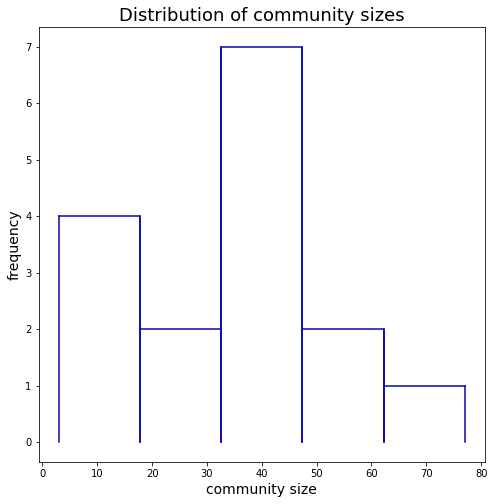

In [14]:
custom_histogram(community_sizes,"Distribution of community sizes","community size","frequency")

The most of the communities contains between 2 and 14 politicians. 
Two of the communities has between 55 and 83 politicians. 

In [ ]:
##### SAVING THE COMMUNITIES TO A FILE
#with open('communities.data', 'wb') as filehandle:
    # store the data as binary data stream
#    pickle.dump(partition_GCC, filehandle)

### Concatenating all politicians tweets for each politician

For making wordcloud that could give insight into which topics the politicians in the communities tweets about, a processing of the real text is made. A TF-IDF transformation of the word is made, then wordclouds shows the words that characterize the communities. 

Before doing the tf-idf transformation, all the tweets for each politician is concatenated.

In [ ]:
#with open('tweet_dict_all_v2.data', 'rb') as filehandle:
 #   tweet_dict_onlytext = pickle.load(filehandle)     

In [ ]:
#dict_concat=dict()

In [ ]:
#for pol in list(tweet_dict_onlytext.keys()):
#    dict_concat[pol]=' '.join(tweet_dict_onlytext[pol])
#    dict_concat[pol] = re.sub(r"http\S+", "", dict_concat[pol]) #remove links
    

In [ ]:
#with open('tweet_concat_v2.data', 'wb') as filehandle:
    # store the data as binary data stream
#    pickle.dump(dict_concat, filehandle)

In [ ]:
with open('tweet_concat_v2.data', 'rb') as filehandle:
    dict_concat = pickle.load(filehandle)     

Before building the TF list, both english and danish stopwords are 

In [ ]:
stopwords_danish = stopwords.words('danish')

In [ ]:
STOPWORDS=STOPWORDS.union(stopwords_danish)
STOPWORDS=STOPWORDS.union(["rt"])# RT is some twitter syntax 

In [ ]:
largest_communities=list(set(partition_GCC.values()))

In [ ]:
community_text =  dict()
TF_dc = dict()


for i in range(len(largest_communities)):

   
    common_characters = [k for k,v in list(partition_GCC.items()) if v == largest_communities[i]]

    # reset collection of words for each community
    dc_words=[]

    # Tokenize the text in all files in community i and concatenate into one text
    for pol in list(dict_concat.keys()):
            if pol in common_characters:
              
                dc_words += nltk.word_tokenize(dict_concat[pol])
    
    # enter all text from community i in a dict
    dc_tokens = [word.lower() for word in dc_words if (word.isalnum() and word.lower() not in STOPWORDS)]
    #words_lemmatized=[lemmatizer.lemmatize("",t)[0] for t in dc_tokens]
    
    community_text[largest_communities[i]] = dc_tokens

for i in community_text.keys():
    TF_dc[i] = FreqDist(community_text[i])

In [ ]:
# number of words and text
common_communities=largest_communities
for i in range(len(common_communities)):
    print('Community ', common_communities[i],' has ', len(community_text[common_communities[i]]), ' words')

**IDF**

To calculate the TF-IDF we multiply TF and IDF with each other. TF is the raw count of any word in each community and IDF is the *Inverse Document Frequency Smooth*: $log\frac{N}{n_t+1}+1$,
where $N$ is the total number of communities and $n_t$ is the total number of communities which contains the term $t$.


The motivation behind using this formula is that it gives a high score for a word that is frequent in few communities and a low score for words that are frequent in many communities. This way, the result indicates words that are especially significant to the individual communities and hence relevant in a wordcloud.


We use the raw count (TF weighting scheme), because we expect the wikitext in the communities to be rather similar, mainly differing in the mentioning and description of specific characters and catch phrases. Furthermore, stopwords are excluded. If these were included it might have been preferable to use another measure for TF.



In [ ]:
#inverse document frequency
def IDF_for_word(word, this_com_name, TF_other_community, N):
 
    nt=0
 
    for com in list(TF_other_community.keys()):
        if word in TF_other_community[com] and com != this_com_name:
            nt = nt+1
 
    w_IDF=np.log(N/(nt+1))+1
    return w_IDF

In [ ]:
IDF = dict()

for community in TF_dc.keys():
    IDF.update({community: {}})
    for word in TF_dc[community].keys():
        IDF[community].update({word: IDF_for_word(word, community, TF_dc, 7)})

In [ ]:
TF_IDF = dict()

for community in TF_dc.keys():
    TF_IDF.update({community: {}})
    for word in TF_dc[community].keys():
        TF_IDF[community].update({word: TF_dc[community][word]*IDF[community][word]})

In [ ]:
twitter_mask=np.array(Image.open('twitter_sil.jpg'))

In [ ]:
STOPWORDS=STOPWORDS.union(['dkpol','se','få','komme'])# RT is some twitter syntax 

In [ ]:
#flere verber: http://fjern-uv.dk/250.pdf

In [ ]:
SWs=set(STOPWORDS)

In [ ]:
for community in TF_IDF.keys():
    community_WordCloudText = ' '.join([word for word in list(TF_IDF[community].keys()) for i in range(math.ceil(TF_IDF[community][word]))])

    plt.figure(figsize=(10,20))
    community_wordcloud = WordCloud(collocations=False, mask=twitter_mask, background_color='white', stopwords=SWs).generate(community_WordCloudText)
    plt.imshow(community_wordcloud, interpolation='bilinear')
    plt.savefig('com_wordclouds/community'+str(community)+'.png')
    plt.title(label=('Community '+str(community)))
    plt.axis("off")

Extracting the 8 largest communities to have an appropiate amount of politicians in each community.

In [ ]:
largest_communities=[i for i in b.most_common(8)]

In [ ]:
largest_communities

In [ ]:
G_com_6=giant.subgraph([k for k in list(partition_GCC.keys()) if partition_GCC[k]==6 ])
G_com_3=giant.subgraph([k for k in list(partition_GCC.keys()) if partition_GCC[k]== 3])
G_com_0=giant.subgraph([k for k in list(partition_GCC.keys()) if partition_GCC[k]==0 ])
G_com_4=giant.subgraph([k for k in list(partition_GCC.keys()) if partition_GCC[k]==4 ])
G_com_12=giant.subgraph([k for k in list(partition_GCC.keys()) if partition_GCC[k]==12 ])
G_com_8=giant.subgraph([k for k in list(partition_GCC.keys()) if partition_GCC[k]==8])
G_com_9=giant.subgraph([k for k in list(partition_GCC.keys()) if partition_GCC[k]==9 ])
G_com_1=giant.subgraph([k for k in list(partition_GCC.keys()) if partition_GCC[k]==1 ])

In [ ]:
print("Community 6 is named: "+' & '.join([x[0] for x in sorted(G_com_6.degree, key=lambda x: x[1], reverse=True)[:3]]))
print("Community 3 is named: "+' & '.join([x[0] for x in sorted(G_com_3.degree, key=lambda x: x[1], reverse=True)[:3]]))
print("Community 0 is named: "+' & '.join([x[0] for x in sorted(G_com_0.degree, key=lambda x: x[1], reverse=True)[:3]]))
print("Community 4 is named: "+' & '.join([x[0] for x in sorted(G_com_4.degree, key=lambda x: x[1], reverse=True)[:3]]))
print("Community 12 is named: "+' & '.join([x[0] for x in sorted(G_com_12.degree, key=lambda x: x[1], reverse=True)[:3]]))
print("Community 8 is named: "+' & '.join([x[0] for x in sorted(G_com_8.degree, key=lambda x: x[1], reverse=True)[:3]]))
print("Community 9 is named: "+' & '.join([x[0] for x in sorted(G_com_9.degree, key=lambda x: x[1], reverse=True)[:3]]))
print("Community 1 is named: "+' & '.join([x[0] for x in sorted(G_com_1.degree, key=lambda x: x[1], reverse=True)[:3]]))

In [ ]:
community_val_to_name={
    6:'regeringDK & sophieloehde & JakobEllemann',
    3: 'FrankJensenKBH & nikogrunfeld & Jonasbjorn',
    0: 'oestergaard & sofiecn & KHegaard',
    4: 'larsloekke & Kristian_Jensen & EvaKjerHansen',
    12: 'Heunicke & stephanie_lose & SophieHAndersen',
    8:'jacobmark_sf & PiaOlsen & Carl__Valentin',
    9:'PSkipperEL & PerClausen3 & RosaLundEl',
    1:'SchaldemoseMEP & MarianneVind & JanEJoergensen'
    
    
}

**Conclusion:**

The 6 community with regeringDK, sophielehde and JakobElleman, talks about "randerspol", "regeringen", "horsenspol"



The 3 community with FrankJensenKBH & marvesterager & nikogrunfeld, talks about "koebenhavner", "friegronne", "fannybroholm", "kbhpol"


The 0 community with oestergaard & sofiecn & KHegaard, talks about "radikale", "helsingørpol", "opdagdanmark", "gin"


The 4 community with larsloekke & Kristian_Jensen & engelschmidt, talks about "DRtrekanten", "kolding", "igniteesportdk", "sønderborgpol"

The 12 community with Heunicke & stephanie_lose & Astridkrag, talks about "regionerne", "regionsjaelland", "sundpol", "dksocial","nsrsygehuse"

The 8 community with jacobmark_sf & PiaOlsen & Carl__Valentin, talks about "sfkolding", "sfpolitik", "parkinson", "merekisser","sf"

The 9 community with PSkipperEL & PerClausen3 & RosaLundEl, talks about "aalpol", "enhedslisten", "pelledragsted", "xrp1procent"

The 1 community with MarianneVind & karmel80 & JanEJoergensen, talks about "eudk", "ep", "eurosportdk"









For plotting the communities into clusters in a nx Graph, inspiration has been taken from this [StackOverflow question](https://stackoverflow.com/questions/43541376/how-to-draw-communities-with-networkx). First creating a graphs, containing the nodes of the largest comunities:

In [ ]:
have_with=[k for k in list(partition_GCC.keys()) if partition_GCC[k] in [i[0] for i in largest_communities] ]

In [ ]:
giant2=giant.subgraph([k for k in list(partition_GCC.keys()) if partition_GCC[k] in [i[0] for i in largest_communities] ])

In [ ]:
partition_GCC_shorterlist = { your_key: partition_GCC[your_key] for your_key in have_with }

In [ ]:
set(list(partition_GCC_shorterlist.values()))

In [ ]:
col=["red","darkorange","olivedrab","yellow","cyan","blue","darkviolet","lime"]
val_to_col={0:0,1:1,3:2,4:3,6:4,8:5,9:6,12:7}

color_list_custom=[col[val_to_col[n]] for n in list(partition_GCC_shorterlist.values())]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

def community_layout(g, partition):
    """
    Compute the layout for a modular graph.


    Arguments:
    ----------
    g -- networkx.Graph or networkx.DiGraph instance
        graph to plot

    partition -- dict mapping int node -> int community
        graph partitions


    Returns:
    --------
    pos -- dict mapping int node -> (float x, float y)
        node positions

    """

    pos_communities = _position_communities(g, partition, scale=3.)

    pos_nodes = _position_nodes(g, partition, scale=1.)

    # combine positions
    pos = dict()
    for node in g.nodes():
        pos[node] = pos_communities[node] + pos_nodes[node]

    return pos

def _position_communities(g, partition, **kwargs):

    # create a weighted graph, in which each node corresponds to a community,
    # and each edge weight to the number of edges between communities
    between_community_edges = _find_between_community_edges(g, partition)

    communities = set(partition.values())
    hypergraph = nx.DiGraph()
    hypergraph.add_nodes_from(communities)
    for (ci, cj), edges in between_community_edges.items():
        hypergraph.add_edge(ci, cj, weight=len(edges))

    # find layout for communities
    pos_communities = nx.spring_layout(hypergraph, **kwargs)

    # set node positions to position of community
    pos = dict()
    for node, community in partition.items():
        pos[node] = pos_communities[community]

    return pos

def _find_between_community_edges(g, partition):

    edges = dict()

    for (ni, nj) in g.edges():
        ci = partition[ni]
        cj = partition[nj]

        if ci != cj:
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]

    return edges

def _position_nodes(g, partition, **kwargs):
    """
    Positions nodes within communities.
    """

    communities = dict()
    for node, community in partition.items():
        try:
            communities[community] += [node]
        except KeyError:
            communities[community] = [node]

    pos = dict()
    for ci, nodes in communities.items():
        subgraph = g.subgraph(nodes)
        pos_subgraph = nx.spring_layout(subgraph, **kwargs)
        pos.update(pos_subgraph)

    return pos

def test():
    # to install networkx 2.0 compatible version of python-louvain use:
    # pip install -U git+https://github.com/taynaud/python-louvain.git@networkx2
    from community import community_louvain

    g = giant2
    #partition = community_louvain.best_partition(g) #If no partition has been made
    pos = community_layout(g, partition_GCC_shorterlist)
    d = dict(g.degree(g.nodes()))

    plt.figure(figsize=(30,10))
    #nx.draw(g, pos,alpha=0.5, node_color=list(partition.values()),node_size=[v * 10 for v in d.values()]); plt.show()
    
    nx.draw_networkx_edges(g, pos, alpha=0.1)
    #nx.draw_networkx_nodes(g, pos, alpha=0.9,node_size=50,node_color=list(partition_GCC_shorterlist.values()))
    nx.draw_networkx_nodes(g, pos, alpha=0.9,node_size=50,node_color=color_list_custom)
    #nx.draw_networkx_nodes(g, pos, alpha=0.35,node_color=list(partition.values()),node_size=[v * 3 for v in d.values()])
    
    #Plot labels
    list_set=list(set(list(partition_GCC_shorterlist.values())))
    patches=[]
    for i in list_set:
        patch = mpatches.Patch(color=col[val_to_col[i]], label='Community: '+str(community_val_to_name[i]))
        patches.append(patch)
        
    plt.legend(handles=patches,loc=2,prop={'size': 20},bbox_to_anchor=(0, 0),ncol=2)
   
    plt.show()
    
    return

In [ ]:
test()

## Analysis step 3: Parties and Sentiment (CHRISTIAN)

We want to analyze the sentiment score that the tweets have associated to them, moreover we want to get an idea of how cross party tweets are scored. This could for example, show that a certain party may agree more, on average than an other party, would this be as expected regarding the block politics we've described earlier? This is what we look to find out

In [ ]:
#!pip install afinn
#!pip install langdetect
from tqdm.notebook import tqdm

from langdetect import detect
from afinn import Afinn
afinn = Afinn()
afinn_da = Afinn(language='da')

In [ ]:
with open('tweet_dict_listversion_wrealnames_v2.data', 'rb') as filehandle:
    tweet_dict = pickle.load(filehandle) 

In [ ]:
# helper function
def get_party(node):
    # returns party of a node
    x = data.loc[data['Twittername'] == node]    
    for w in x['Party']: # returns one item couldn't do x['Party'][0] for some reason
        return w

In [33]:
# for each tweet calculate a score 
# get from party and to party
# update total
count = 0

for key,value in tqdm(tweet_dict.items()):
    #print(key)
    from_party = get_party(key)
    for mention, texts in value.items():
        to_party = get_party(mention)
        for tweet in texts:
            # remove @s
            tweet = re.sub(r'@\w+\b', '', tweet)
            tweet = tweet.strip()
            try:
                lang = detect(tweet)
            except Exception as e:
                print(e)
                print("tweet = " + tweet)
                continue # skip
            if lang == 'da':
                score = afinn_da.score(tweet)
            elif lang == 'en':
                score = afinn.score(tweet)
            else:
                score = afinn_da.score(tweet)
                print(tweet)
                print("Language    " + lang)
                print("debug: " + str(afinn_da.score(tweet)))
                continue

            try:
                total_sentiment[from_party][to_party]['scores'].append(score)
            except Exception as e:
                print("Error" + str(e))
                #print("Backlog: ")
                #print("tweet from "  + key + " to " + mention)


Tillykke!!
Language    no
debug: 2.0
I er velkomne 😀- god sommer. https://t.co/TQCVvAlOpm
Language    no
debug: 3.0
Men du fik din historie alligevel. Skam dig! https://t.co/cPD6ZmMAg9
Language    af
debug: 0.0
(du svarede så prompte på mit første opslag, så kan du ikke også svare på dette?)
Language    no
debug: 0.0
Og det fortalte i ham så?
Language    no
debug: 0.0
I know.
Language    pl
debug: 0.0
Nok for meget forlangt. 😄
Language    no
debug: -2.0
RT :  Flot grøn alliance , , , ,  , 

Vil …
Language    it
debug: 3.0
RT : Selv tak  Tak fordi du har gjort  til et skoleparti igen bl.a. ved at prioritere flere lærere på fina…
Language    no
debug: 4.0
RT : Christian Fuhlendorff og  går to ture og snakker klima, kunstig intelligens, troen på fremtiden, tillid til…
Language    no
debug: 2.0
Tillykke begge to!
Language    no
debug: 2.0
Stort tillykke
Language    no
debug: 2.0
Du laver forhåbentlig sjov. Det var virkelig en fordomsfuld, usympatisk og verdensfjern kommentar. Du har da vis

No features in text.
tweet = 💪💚
RT : Man har kun brug for en hockey-stav, hvis man er på glatis. 
Støtter  egentlig reelt 70-procents målet? Så vis os…
Language    no
debug: 2.0
Det har du misforstået så. Hun svarede på spørgsmål fra BT.
Language    no
debug: -2.0
Vi har ikke trukket den frem. Vi har svaret på spørgsmål pressen stiller. Og jeg tror ikke det kan undgås at en sag der for mig er klokkeklar #metoo tages frem.
Language    no
debug: -1.0
Det har du misforstået så. Hun svarede på spørgsmål fra BT.
Language    no
debug: -2.0
Kæmpe respekt. Tak 🙌❤️
Language    no
debug: 3.0
Tak 💚
Language    id
debug: 2.0
statsministeriet bliver styrket #dkpol https://t.co/8uarlo0vm3
Language    no
debug: 2.0
ErrorNone
ErrorNone
ErrorNone
ErrorNone
RT : 13 projekter, som vil styrke den grønne omstilling i landbrugs- og fødevaresektoren, får tilsammen knap 100 mio. kroner fra …
Language    no
debug: 2.0
ErrorNone
ErrorNone
ErrorNone
ErrorNone
ErrorNone
ErrorNone
ErrorNone
RT : Bred klimaaftale m

Stort tillykke, Sophie💪🏻😊
Language    no
debug: 2.0
RT : Selvfølgelig skal rammerne for genåbning være trygge. Det mener vi også i  - vi skal passe på risikogrupper bland…
Language    no
debug: 1.0
Stort tillykke til  med sin første tjans i formandsstolen 😃😎🇩🇰 #dkpol https://t.co/RCZVUdTYDp
Language    no
debug: 2.0
RT : Klar med    på #Verdenspressen på  - vi snakker USA, Hong Kong, Kashmir mm.…
Language    no
debug: 1.0
Kunne man tilføje download app til disse skilte? #Covid19dk https://t.co/kOOQ26dT3N
Language    no
debug: 0.0
5te gang er lykkens gang... nu er min app store også opdateret
Language    no
debug: 3.0
Har ventet siden maj tror jeg 😂 men ja
Language    no
debug: 1.0
Fysisk eller psykisk?
Language    no
debug: 0.0
Ahhh
Language    vi
debug: 0.0
Hørt!
Language    no
debug: 0.0
Hørt!
Language    no
debug: 0.0
Modtaget! Vi presser på.
Language    no
debug: 0.0
RT : Interessant indspark i debatten om #DR fra : https://t.co/uR7OVKSl3o #dkpol
Language    no
debug: 2.0
Enig!
Lan

Vi styrker kontrollen med dyretransporter. For dyrenes skyld. Tak for konstruktive snakke og for en bred aftale til , , , , , , , , ,  #dkpol https://t.co/GXAstOquzf
Language    no
debug: 3.0
Vi styrker kontrollen med dyretransporter. For dyrenes skyld. Tak for konstruktive snakke og for en bred aftale til , , , , , , , , ,  #dkpol https://t.co/GXAstOquzf
Language    no
debug: 3.0
RT : Stort tillykke til  med 40 års jubilæum i  Fortjente blomster og klapsalver fra  https:…
Language    no
debug: 2.0
RT : Stort tillykke til  med 40 års jubilæum i  Fortjente blomster og klapsalver fra  https:…
Language    no
debug: 2.0
RT : Ingen er i tvivl om forskellen på kompliment og sexistisk kommentar. Det første gør glad. Det andet gør knastør i trussen. At…
Language    no
debug: 2.0
Åhh Mai. Tror muligvis jeg elsker dig. 😂❤️😂😍
Language    no
debug: 2.0
Så fik jeg byttet rundt og  fik mit like i stedet 😂
Language    no
debug: 4.0
RT : Positivt, at S åbner for skattelettelser i  i morgen. Det er pot

Jeg kunne svare: Sikke en latterlig kommentar. Men fortæl hellere hvad du mener og hvorfor?
Language    no
debug: -2.0
Damn. Jeg er nr 57 med mine 8 arter 👀. Men alle mine fotos er fra i dag. Ikke gamle anemoner fra i foråret 💪😇💚
Language    no
debug: 0.0
ErrorNone
ErrorNone
ErrorNone
ErrorNone
Tak😀
Language    sw
debug: 2.0
Jeg kunne svare: Sikke en latterlig kommentar. Men fortæl hellere hvad du mener og hvorfor?
Language    no
debug: -2.0
Damn. Jeg er nr 57 med mine 8 arter 👀. Men alle mine fotos er fra i dag. Ikke gamle anemoner fra i foråret 💪😇💚
Language    no
debug: 0.0
Damn, jeg nakkede to mejeredderkopper i går. Skulle ha' ventet og fotograferet dem først :-) Jeg må på jagt efter noget andet. Super initiativ 💪🦋🕷️🐌🐞🐛
Language    no
debug: 5.0
Jeg kunne svare: Sikke en latterlig kommentar. Men fortæl hellere hvad du mener og hvorfor?
Language    no
debug: -2.0
Jeg kunne svare: Sikke en latterlig kommentar. Men fortæl hellere hvad du mener og hvorfor?
Language    no
debug: -2.0
De

First like!
Language    no
debug: 0.0
Ja præcis 😋
Language    pt
debug: 3.0
tak for opklaring. Det kunne godt forstås anerledes
Language    no
debug: 5.0
First like!
Language    no
debug: 0.0
First like!
Language    no
debug: 0.0
No features in text.
tweet = 💛💙💛💙
*NC3
Language    vi
debug: 0.0
First like!
Language    no
debug: 0.0
First like!
Language    no
debug: 0.0
first like!
Language    no
debug: 0.0
*NC3
Language    vi
debug: 0.0
*NC3
Language    vi
debug: 0.0
i deres FRITID!
Language    ca
debug: 0.0
Mange tak Uffe🙏🏼
Language    id
debug: 2.0
RT : #dkpol  https://t.co/uMePeKj0Cf
Language    sk
debug: 0.0
Mange tak Uffe🙏🏼
Language    id
debug: 2.0
Mange tak Uffe🙏🏼
Language    id
debug: 2.0
No features in text.
tweet = https://t.co/UYC7WqHulv
Fra de to partiers mund
Language    es
debug: 0.0
Skattelylisten skal strammes op - og de europæiske skattely skal ikke kunne undtages  #eudk #dkpol https://t.co/dcm9jgdYq6
Language    no
debug: 0.0
Enig Michael!
Language    de
debug: 1.0
Don

RT : Hvad skal med i DK's kommende handlingsplan for #Verdensmålene? Fint anslag fra   og .  
https…
Language    no
debug: 2.0
RT : Denne rapport er en blinkende alarm 😢

Sent anbragte kæmper med selvskade, misbrug, kriminalitet og dårlig trivsel. Vi skal…
Language    no
debug: -13.0
RT : Snart 40 år i centraladministrationens og statens tro tjeneste - og de seneste 25 år i rollen som departementschef i …
Language    no
debug: 1.0
Dansk Kyst- og Naturturisme overrækker mandag ny handlingsplan for outdoorturismen, og erhvervsminister  kommer på banen for at kvittere. Mountainbike-banen faktisk. Læs mere her: https://t.co/fdMD1u9edY #dkjournos #dkturisme #cykelland #dkoutdoor #nordjylland https://t.co/80XTNnW9Nz
Language    no
debug: 0.0
Helt enig 👍
Language    nl
debug: 1.0
Helt enig 👍
Language    nl
debug: 1.0
Helt enig 👍
Language    nl
debug: 1.0
Helt enig 👍
Language    nl
debug: 1.0
Helt enig 👍
Language    nl
debug: 1.0
Helt enig 👍
Language    nl
debug: 1.0
Tillykke 👏🇩🇰👏
Language    

RT :    Vi koordinerer jo 😂😂💚💚 https://t.co/ECMEYe74ha
Language    no
debug: 0.0
RT :    Vi koordinerer jo 😂😂💚💚 https://t.co/ECMEYe74ha
Language    no
debug: 0.0
Fynsk rygeost er fantastisk
Language    no
debug: 4.0
Tillykke til  ,  og  som nye ministre. Jakob har gjort det fantastisk som politisk ordfører, Eva er driftssikker og Tommy bliver en spændende fornyelse 👍🏻 #dkpol
Language    no
debug: 9.0
Tillykke til  ,  og  som nye ministre. Jakob har gjort det fantastisk som politisk ordfører, Eva er driftssikker og Tommy bliver en spændende fornyelse 👍🏻 #dkpol
Language    no
debug: 9.0
RT :    Vi koordinerer jo 😂😂💚💚 https://t.co/ECMEYe74ha
Language    no
debug: 0.0
RT : Venstre goes green 👍🌍 https://t.co/k69GILezVz  #dkpol #energi https://t.co/s9pOTWUQ4J
Language    af
debug: 0.0
så er jeg klar til at svare på spørgsmål til regeringen på p1👍#dkpol #dkmedier https://t.co/vgvp21mi9z
Language    no
debug: 1.0
RT : God finanslovsdebat til hele #dkpol i dag 👍
 
Og tak til  for et godt svar p

Hov hov. Kast ikke med sten når du bor i et glashus  
Det er et relevant spg. fra   og I  spreder jo selv konstant #fakenews. Se bare Aalborg Portland. Pinligt. Fej for egen dør. https://t.co/Ciqy9TBYm1
Language    no
debug: -3.0
RT : Der venter en stor regning for nedlukningen. Heldigvis er 🇩🇰 godt rustet. Det har , , …
Language    no
debug: 5.0
RT : Der venter en stor regning for nedlukningen. Heldigvis er 🇩🇰 godt rustet. Det har , , …
Language    no
debug: 5.0
RT : Der venter en stor regning for nedlukningen. Heldigvis er 🇩🇰 godt rustet. Det har , , …
Language    no
debug: 5.0
RT : DANMARK ER VENSTREBLÅT ❤️💙🇪🇺🇩🇰 #EP2019 #FV19 #dkpol https://t.co/iU2ZdDANTS
Language    de
debug: 0.0
Tillykke med valget 👍🏼
Language    no
debug: 2.0
Tillykke med i morgen 🇩🇰
Language    no
debug: 2.0
Det har du fuldkommen ret i  https://t.co/2Dt0FxSekZ
Language    no
debug: 0.0
Tak. Det er simpelthen så grotesk!
Language    no
debug: -1.0
Tillykke! Sejt 👊🏼
Language    no
debug: 2.0
Respekt!
Language    

RT : Børnenes finanslov ❤️ https://t.co/yVLGIoP5Ad
Language    no
debug: 0.0
RT : Hvad f..... har hun gang i!! Ikke stemme på søndag ! I Danmark hvor vi har folkestyre og demokrati. Fordi NB ikke selv…
Language    no
debug: 0.0
rt : hver anden nye coronasmittede i aarhus er somalier – helt grotesk, mener pia kjærsgaard - https://t.co/5c6emynbzn http…
Language    no
debug: -3.0
RT : Den Korte Avis | DF-ikonet Søren Krarup er atter aktiv – støtter Martin Henriksen i hans valgkamp: https://t.co/ZlyHKhr4IB
Language    no
debug: 3.0
hvem har talt mest om islam fra folketingets talerstol? marie krarup! nr to er christian langballe! så sig ikke, at vi ikke har sat islam på dagsordenen. 
https://t.co/t1u3cyzas1
Language    no
debug: 0.0
Ja. Ret interessant. :-) https://t.co/6OQnVFqYfr
Language    de
debug: 3.0
Hvornår vil vi kunne teste 5.000 om dagen? Kan  svare? #dkpol https://t.co/ns5Wy96whJ
Language    no
debug: 0.0
jeg synes godt nok  skylder en forklaring her: hvorfor skulle der gå så la

No features in text.
tweet = 💛💙
Du kan simpelthen ikke se problemet i, at du er hellig som paven, mens du selv bryder reglerne fordi du skal i Det Kongelige med dine venner? Jeg har lært at man skal feje foran sin egen dør først
Language    no
debug: 0.0
Hvilket mønster vil du sige at du viser her, Peter? Man skal ikke kaste med sten når man selv bor i glashus: https://t.co/34bMoSPsSm
Language    no
debug: 1.0
No features in text.
tweet = 🤦‍♂️🤦‍♂️
No features in text.
tweet = 💛💙
No features in text.
tweet = 💛💙
No features in text.
tweet = 💛💙
No features in text.
tweet = 💛💙
Vi må have samme slags spam-filter. Pokkers!
Language    no
debug: -6.0
RT : 💪💪💪💪 kilde: NB-Økonomo #dkpol https://t.co/mTBqf6Cvfs
Language    sl
debug: 0.0
RT : Hovsa Mette! Overbetaling??? Prøv lige at tjekke fakta. #dkpol #fv19 https://t.co/5sCITYL5Px
Language    no
debug: 0.0
Det måtte jo komme på et tidspunkt 😂😂
Language    no
debug: 0.0
Sikke noget vrøvl!
Language    no
debug: 0.0
Sikke noget vrøvl!
Language   

jeg har spurgt regeringen til, hvad denne type diplomatiske forsikringer giver anledning til i fremtiden. jeg venter endnu på svaret
Language    no
debug: -1.0
Jeg har stillet spørgsmål til ministeren om netop dette!
Language    no
debug: 0.0
Jeg har stillet spørgsmål til ministeren om netop dette!
Language    no
debug: 0.0
Jeg har stillet spørgsmål til ministeren om netop dette!
Language    no
debug: 0.0
:     Virker ellers som om at de smider mange Q-kommentarer i V. http://t.co/xLh35uUcw9
Language    no
debug: 0.0
No features in text.
tweet = ...https://t.co/LgAgTodLPH
Og han bekræfter igen og igen, at han ville have tøvet, gjort som Sverige mv.
Language    no
debug: 0.0
No features in text.
tweet = ...https://t.co/LgAgTodLPH
Lyt lyt lyt :)
Language    fi
debug: 0.0
Selv tak fra en far til to piger..
Language    no
debug: 2.0
Helt fantastisk dag 🙏👏💪🤝❤️
Language    no
debug: 4.0
Selv tak fra en far til to piger..
Language    no
debug: 2.0
Helt fantastisk dag 🙏👏💪🤝❤️
Language    no
deb

Ja!
Language    sw
debug: 1.0
Du kan jo spørge den ansvarlige minister.  Han svarede ret klart i Politiken i søndags. Og i og med han har været ansvarlig for de førte forhandlinger, ved han nok, hvad han taler om.
Language    no
debug: 3.0
ErrorNone
rt : s-regeringen og mette f gav topskattelettelser. vil de rulle dem tilbage? nej. det er meget sjovere at beskylde v for top…
Language    no
debug: 3.0
No features in text.
tweet = 💚🙏🏼
RT : Derfor forventer jeg også stor opbakning til beslutningsforslaget om en Biodiversitetslov den 10.november.
Language    no
debug: 2.0
RT : Yes! 

#Elections2020 #dkpol
Language    fr
debug: 2.0
strakspåbud og forbud er oppe på 80 på storstrømsbroen.
det er en skandale. det bør stoppes.
jeg har beskæftigelsesminister peter hummelgaard i samråd mandag kl. 14. #dkpol https://t.co/w2qy4svwai
Language    no
debug: -5.0
No features in text.
tweet = 💪😂
Tusind tak Jesper!🙏
Language    id
debug: 2.0
Ej Ellen, du er sgu bedre end det. Ingen skjuler noget og Mølba

Tak for din hilsen Birgit.
Jeg har altid kunnet lide dig og din dømmekraft. Dømmekraften hvad angår ishockey, - det er en ommer 😊😉
Language    no
debug: 4.0
Selv tak min ven. 
Også fordi du overkommer det store hverv som KL-formand. Til gavn for mange. Bh Lars
Language    no
debug: 4.0
Mange tak Steen. Og hold kommune-fanen højt.
Language    no
debug: 2.0
Genkendt😎. Brdr. Price, Herning 👍 https://t.co/WdYj3eBWgB
Language    de
debug: 0.0
Jamen så mangler “vi” jo bare de tre mia... 😉🥴
Language    no
debug: -2.0
No features in text.
tweet = 😉👍 https://t.co/PWVzYlqbJf
No features in text.
tweet = 😉👍 https://t.co/PWVzYlqbJf
Begge dele
Language    no
debug: 0.0
Ha ha ha - du er i Herning. Men tryg  (ikke tryk...😂😂)
Language    no
debug: 8.0
Jamen så mangler “vi” jo bare de tre mia... 😉🥴
Language    no
debug: -2.0
RT : Kun ét år til vi skal til kommunal- og regionalvalg,  på #rvlm20. Demokratiet er noget vi deler med hinanden. Og…
Language    no
debug: 0.0
Måske skulle mit deep learning proj

ErrorNone
Stort tillykke til  og Inger Støjberg. Det skal nok blive godt. 👍 #dkpol #velm19 https://t.co/uW3DHvx8KY
Language    no
debug: 5.0
Tak Karen!
Language    id
debug: 2.0
vi ønsker en plan fra venstre hr. lars løkke rasmussen.#dkpol
Language    no
debug: 2.0
jacob jensen gav jo ikke svar på om dagpengene skulle skæres, kom dog med et svar, ja eller nej #dkpol
Language    no
debug: 0.0
nye toner fra venstre. torsten schack mener det er ok, at df kan love alt hvad de vil, 364 dage om året, bare ikke i finansloven.#dkpol
Language    no
debug: 0.0
ErrorNone
ErrorNone
ErrorNone
ErrorNone
ErrorNone
mangler stadig at svare, Ole 🙂
Language    sv
debug: -2.0
ErrorNone
Jeg støtter ikke forslaget om at forbyde navnet “grønne burgere”. Jeg elsker faktisk både grønne burgere og grønne pølser 😋
Language    no
debug: 2.0
ErrorNone
ErrorNone
ErrorNone
ErrorNone
Vi er på linje Troels !
Language    no
debug: 0.0
Jeg stemmer ud fra min overbevisning. Jeg mener ikke EU skal bruge den grønne just tr

Jeg er forresten nu ledig på Fri Transfer 😉
Language    no
debug: 1.0
Jeg er forresten nu ledig på Fri Transfer 😉
Language    no
debug: 1.0
Heller ikke
Language    no
debug: 0.0
Heller ikke.
Language    no
debug: 0.0
Det var det ikke nej
Language    no
debug: -1.0
Hun er radikal. Så nej - det var ikke en radikal
Language    no
debug: -1.0
Heller ikke
Language    no
debug: 0.0
Heller ikke.
Language    no
debug: 0.0
Det var det ikke nej
Language    no
debug: -1.0
Hun er radikal. Så nej - det var ikke en radikal
Language    no
debug: -1.0
Heller ikke
Language    no
debug: 0.0
Heller ikke.
Language    no
debug: 0.0
Heller ikke
Language    no
debug: 0.0
No features in text.
tweet = https://t.co/F7855bSHcP
Tak Kristian🥰
Language    id
debug: 2.0
Min personlige historie
Language    af
debug: 0.0
Sejt!
Language    sq
debug: 0.0
RT : Kontakttallet for smittede er faldet fra 1,5 til 1,3. Smitten stiger altså fortsat, men i lavere tempo. Vi skal under 1, før…
Language    no
debug: -6.0
RT : Konta

Det er jo jer man kunne sige, at politik gør en forskel
Language    no
debug: 0.0
Hørt
Language    no
debug: 0.0
Hørt
Language    no
debug: 0.0
Se her hvad   har gjort https://t.co/otPuG8nxIG
Language    no
debug: 0.0
No features in text.
tweet = 👏🏼👏🏼👏🏼👏🏼
No features in text.
tweet = ❤️❤️
No features in text.
tweet = 🥰
ErrorNone
Se her :-) https://t.co/RCxK9t5o6t
Language    de
debug: 0.0
Brobygning og studiedage er simpelthen bare noget I maner man kan og skal spare væk? Det mener jeg i hvert fald ikke!
Language    no
debug: 0.0
Det er min klare forventning.
Language    no
debug: 0.0
Do it!😂
Language    de
debug: 0.0
Do it!😂
Language    de
debug: 0.0
RT : Corona-epidemi skal ikke føre til finanskrise. Landets førende økonomer opfordrer til en 300 mia. stor statslig krisefond.…
Language    no
debug: 0.0
Hvordan ønsker I så at finansiere det? Det kunne vi i hvert fald ikke få svar på i salen i fredags.
Language    no
debug: 2.0
Selv tak - jeg håber du ved, at vi vil gøre, alt hvad vi ka

VI vil ha’ flere!!
Language    no
debug: 2.0
VI vil ha’ flere!!
Language    no
debug: 2.0
RT : Slingrekurs i  på grønne biler. Først mente V 1 mio grønne biler. Men da prisen stod klar, slog  bak "…
Language    no
debug: 0.0
Måske.
Language    no
debug: 0.0
RT : Slingrekurs i  på grønne biler. Først mente V 1 mio grønne biler. Men da prisen stod klar, slog  bak "…
Language    no
debug: 0.0
Nok meget godt at man ikke driver samfundsøkonomien med din vennetjenestelogik.
Language    no
debug: 3.0
ErrorNone
Var ikke obs på nye regler. Tager det i mig igen.
Language    no
debug: 0.0
Nej.
Language    sk
debug: -1.0
Tak  💪❤️ #dkpol https://t.co/FMo0tVsKer
Language    id
debug: 2.0
RT : #dkpol https://t.co/RB4OsCwlwF
Language    sk
debug: 0.0
Tænkte nok 👍🙏
Language    no
debug: 0.0
Sejt gået  💚❤️💚
Language    sq
debug: 0.0
Sejt gået  💚❤️💚
Language    no
debug: 0.0
Og du var fantastisk ❤️💚❤️
Language    sv
debug: 4.0
RT : Klima nu! Det kan ikke vente #dkpol #dkgreen
Language    af
debug: 0.0
RT

Tak😊🌹
Language    sw
debug: 2.0
Savner jer, mine kollegaer😞
Language    no
debug: 0.0
God bedring🌹
Language    cy
debug: 3.0
Ha ha ha! Så er det straks meget mere passende😅
Language    no
debug: 6.0
Tror faktisk også Irma har😍
Language    no
debug: 0.0
Tak😍💪🏻🌹
Language    sw
debug: 2.0
Stort tillykke😊🌹
Language    no
debug: 2.0
Mange tak☺️🙏🏻
Language    id
debug: 2.0
Altså du er blevet min yndlings-konser. Så fortjent vil jeg sige😊
Language    no
debug: 1.0
“Knastør i trussen”. Sådan skal det siges! Tak  https://t.co/FoCGWPVlaF
Language    no
debug: 2.0
Tillykke til os🥰🇩🇰🌹
Language    no
debug: 2.0
Wauw😍🚝
Language    sw
debug: 0.0
Enig
Language    de
debug: 1.0
Enig
Language    de
debug: 1.0
Enig
Language    de
debug: 1.0
Det er sgu god humor 😂😂😂
Language    cy
debug: 5.0
Mona Vinter 😂
Language    it
debug: 0.0
Helt enig
Language    nl
debug: 1.0
Enig, det må vi regne med at ministeren har gjort.
Language    no
debug: 1.0
Enig, det må vi regne med at ministeren har gjort.
Language    n

RT : På  i dag for at diskutere kommunernes økonomi. Når pengekasserne vokser, skyldes det, at  og …
Language    no
debug: 1.0
RT : "Tulle-torpedo" direkte ind i siden på Løkkes treparts-projekt. Uhørt DF angreb på Løkke. Det sejler i blå blok #dkpol
Language    no
debug: -2.0
RT : På  i dag for at diskutere kommunernes økonomi. Når pengekasserne vokser, skyldes det, at  og …
Language    no
debug: 1.0
RT : Video:  og  om økonomiaftalen #dkpol #kompoldk https://t.co/fyDEdCQ4Cf
Language    no
debug: 0.0
RT : Video:  og  om økonomiaftalen #dkpol #kompoldk https://t.co/fyDEdCQ4Cf
Language    no
debug: 0.0
RT :      I måtte jo vinde engang... Godt spil fra begge hold. #enli…
Language    no
debug: 5.0
Den var legendarisk 😂 (stemte også blankt)
Language    no
debug: 0.0
Godt!
Language    de
debug: 3.0
No features in text.
tweet = ❤️
Seje, seje  ❤️
Language    sl
debug: 0.0
Seje, seje  ❤️
Language    sl
debug: 0.0
No features in text.
tweet = 💪💪💪
Flot    ❤️ https://t.co/VEhNK8m6jV
Language    

enig. vh erling bonnesen (v)
Language    no
debug: 1.0
RT : Stort og varmt velkommen til  nye partisekretær . Jeg er meget glad for, at du takkede ja!
Language    no
debug: 8.0
RT : Ja tak. https://t.co/tc74bn7vTG
Language    id
debug: 3.0
rt : fuld opbakning til jakob ellemann-jensen som ny formand for venstre. han bliver en god formand for venstre #dkpol …
Language    no
debug: 5.0
RT :        Meget klar Venstre lin…
Language    no
debug: 1.0
ErrorNone
ErrorNone
ErrorNone
ErrorNone
ErrorNone
RT :        Meget klar Venstre lin…
Language    no
debug: 1.0
RT :        Meget klar Venstre lin…
Language    no
debug: 1.0
RT :        Meget klar Venstre lin…
Language    no
debug: 1.0
RT :        Meget klar Venstre lin…
Language    no
debug: 1.0
Enig. Vh Erling Bonnesen (V)
Language    de
debug: 1.0
Enig. Vh Erling Bonnesen (V)
Language    de
debug: 1.0
Enig. Vh Erling Bonnesen (V)
Language    de
debug: 1.0
RT : Kanon og velfortjent start for  dygtige nye formand 💪 #dkpol https://t.co/X2PipQcJk

ErrorNone
ErrorNone
ErrorNone
Det kunne være kønt...
Language    no
debug: 0.0
ErrorNone
ErrorNone
ErrorNone
ErrorNone
ErrorNone
ErrorNone
ErrorNone
ErrorNone
ErrorNone
ErrorNone
ErrorNone
ErrorNone
har med  i spidsen travlt med politiske drillerier. Politikere fra V kommer med meldinger i øst og vest.  har heldigvis en sikker hånd på rettet https://t.co/3SzI2ESkm0 #dkpol
Language    no
debug: 5.0
No features in text.
tweet = https://t.co/WtViCR5gUJ
13. Oktober stiller du spørgsmål i dagspressen om det er nødvendig at slå syge mink ihjel. I går ville  have timeout.  mener det går for langsomt med at slå mink ihjel. Det er vist godt  ikke har regeringsansvaret med den slingrekurs.
Language    no
debug: -1.0
No features in text.
tweet = https://t.co/DUCPYFixzh
Ser vi snart planen fra  og  ? https://t.co/WmzElSbK8x
Language    no
debug: 0.0
Vi venter fortsat på svar fra  og  ? https://t.co/FNA6DDp2so
Language    no
debug: -1.0
har med  i spidsen travlt med politiske drillerier. Politikere

Flot, flot åbningstale 👍👍
Language    sv
debug: 6.0
genvalg - tak 👍
Language    af
debug: 2.0
Flot tale Rasmus.
Language    et
debug: 3.0
RT : Leg med og vind, når vi kl. 14.15 inviterer til klassisk bingo med , , Erik Buhl og  p…
Language    no
debug: 1.0
RT : Leg med og vind, når vi inviterer til klassisk bingo med , , Erik Buhl og  lørdag kl.…
Language    no
debug: 1.0
RT : Så rykker vi Pia-mobilen ind på Langeland 😍 Klar til opbakning til  sammen m hans barnebarn ❤️ Ny borgmester JA! #dk…
Language    no
debug: 4.0
RT : Kv17-debat om fjernvarme rykket ind på #lm2017     og Knud Kristensen https://t.…
Language    no
debug: 0.0
RT : Klar til tur til Strynø m  - vi kæmper for borgmesterposten på Langeland #piapåtur #dkpol https://t.co/VXoZxjqnBh
Language    no
debug: -1.0
flemming jensen møder tonni hansen https://t.co/mqzetwsmyi via
Language    no
debug: 0.0
Min gode ven og kammerat   har vundet Folkemødets dialogpris. Så velfortjent! https://t.co/irXSSUUZCy
Language    no
debug: 5.0


Life's a bicht! 🙍🏼‍♀️
Language    de
debug: 0.0
Tak. Det vil jeg gøre. ☺️👍🏻
God påske. 🐣
Language    no
debug: 5.0
Mange tak, Steen. 😊
Language    nl
debug: 2.0
Haha! ❤️Kongehuset❤️
Language    id
debug: 3.0
Mange tak, Steen. 😊
Language    af
debug: 2.0
Var jeg den eneste, som kun kiggede på  skjorte? #dkpol #SamuelsenGate
Language    no
debug: 0.0
RT : Jeg har lovet mig selv, at jeg ikke må sige noget negativt om andre, så jeg siger ikke noget om Fellaini #MUNAND #pldk #el
Language    no
debug: -1.0
195 cm?
Language    vi
debug: 0.0
195 cm?
Language    vi
debug: 0.0
altså samme sted som jeg var i praktik :)
Language    no
debug: 0.0
4) var selv uløn praktikant (med betalt transpor) og er nu student samme sted - not all are black or white
Language    no
debug: 0.0
1. semester + man har lavet noget i praksis før, fx frivillig - hvor ser du problemet?
Language    no
debug: 1.0
Kissmeyer
Language    tr
debug: 0.0
RT : skriver om behov for teknisk forskning: https://t.co/48GbX3UeRe 
#dkpol

Jeps 👍
Language    id
debug: 0.0
No features in text.
tweet = 😂😂😂❤️🌹
TAK til transportminister  https://t.co/XQy0gMzxHq
Language    no
debug: 2.0
Ikke korrekt - hvilke partier på rådhuset har villet forbyde segways - du siger ALLE?
Language    no
debug: 0.0
Ja - så absolut - virker helt helt sort!
Language    no
debug: 1.0
Mama - I made It - to the puzzles! Nu er vores togt med Havhingsten t/r til Dublin i 07/08 også blevet til et puslespil :-) #kultur #kulturpol #dkpol #dkmedier #kbh #kbhpol #Viking    https://t.co/evZqjXVnkP
Language    no
debug: 0.0
No features in text.
tweet = 😂😂😂❤️🌹
Ikke korrekt - hvilke partier på rådhuset har villet forbyde segways - du siger ALLE?
Language    no
debug: 0.0
Helt enig  https://t.co/3D0kpEgJ1A
Language    nl
debug: 1.0
Ja - så absolut - virker helt helt sort!
Language    no
debug: 1.0
Hahahaha 🌹
Language    so
debug: 0.0
No features in text.
tweet = https://t.co/iMcsYkJITw
Hahahaha 🌹
Language    so
debug: 0.0
Ja - så absolut - virker helt helt sor

RT : Fru Sebbelin flytter, og hr.  flytter med: http://t.co/7syaUm0bZH
Language    no
debug: 0.0
Besluttet i dag. Godt for en bosætnings- og erhvervskommune. Ej adm. bøvl 1/1 2015 når krav om timeregistrering
Language    no
debug: 3.0
I svarer udenom
Language    sv
debug: 0.0
At man som kommune placerer sine tildelte flygtninge i en anden kommune... konkret i Valby
Language    no
debug: 0.0
RT : Hvorfor strikker du ikke  ? https://t.co/8bpC9G2mrB
Language    no
debug: 0.0
RT : #cphpride   https://t.co/TDFR7dARI9
Language    pt
debug: 0.0
RT : #cphpride   https://t.co/TDFR7dARI9
Language    pt
debug: 0.0
Nu har jeg prøvet at sige det til dem, men de lytter nok ikke ... https://t.co/RvPQTgwgrt https://t.co/LyA8B2i8Xl
Language    no
debug: 0.0
No features in text.
tweet = 😘
Nu har jeg prøvet at sige det til dem, men de lytter nok ikke ... https://t.co/RvPQTgwgrt https://t.co/LyA8B2i8Xl
Language    no
debug: 0.0
Skal vi bytte? 😂
Language    no
debug: 0.0
Skal vi bytte? 😂
Language    no
deb

No features in text.
tweet = https://t.co/JgKLqyyq3c
Går du ikke lige på toilet? Det ville give #frikadellegate et interessant twist... ;)
Language    no
debug: 2.0
Det er ikke en måling - men en prognose... ;) #randerspol #kv13
Language    no
debug: 0.0
Tak :)
Language    id
debug: 2.0
rt : breaking: lord voldemort er ikke ansvarlig for finansministeriets økonomiske fremskrivninger, erkender corydon http://t.co/oi ...
Language    no
debug: 2.0
Battle til #rvlm14 ml  tale til  og liveinterview med ophidset Marianne Jelved. http://t.co/3MvIUVTCl7
Language    no
debug: 3.0
Battle til #rvlm14 ml  tale til  og liveinterview med ophidset Marianne Jelved. http://t.co/3MvIUVTCl7
Language    no
debug: 3.0
tak!
Language    id
debug: 2.0
battle til #rvlm14 ml  tale til  og liveinterview med ophidset marianne jelved. http://t.co/3mviuvtcl7
Language    no
debug: 3.0
Helt, helt enig ⚠️
Language    nl
debug: 1.0
RT : Endnu en trepartsaftale i hus! Tak til , , , ,  og …
Language    no
debug: 2.0
RT :

RT : . vi vil kigge på penge til aktivitetsområdet på torsdag #budgetmøde https://t.co/jwT34GqPIm
Language    no
debug: 0.0
RT : Tak for #fidusbamsen fra  og  - jeg er meget meget stolt 😍👏🏼👏🏼 #dkpol https://t.co/bIYP3Bg9gq
Language    no
debug: 4.0
RT : Tre regioner, 79 kommuner går netop forrest med at brande  som attraktiv job- og vækst metropol #dkpol  htt…
Language    no
debug: 2.0
Stort tak her fra 😊
Language    no
debug: 2.0
ups 😊
Language    lv
debug: 0.0
husker du fair løsning og villy søvndal (?) 😊
Language    no
debug: 1.0
No features in text.
tweet = 😊
RT :         Keep training, n…
Language    af
debug: 0.0
elisabeth ildal https://t.co/aebj9c1knl
Language    et
debug: 0.0
Debat med bla. , , , , ,  og . http://t.co/gMz5RfzcgR
Language    no
debug: 0.0
Debat med bla. , , , , ,  og . http://t.co/gMz5RfzcgR
Language    no
debug: 0.0
- fantastisk! En sneøls-butterfly! #ringstedgalla
Language    no
debug: 4.0
Så er Ringsteds borgmester også på twitter. Velkommen til .
https://t.c

Flot! Stort tillykke
Language    no
debug: 5.0
RT : Det er da pinligt at indrykke store annoncer. Der både forsimpler og manipulerer - og så ikke kunne forsvare på TV #ftvalg15…
Language    no
debug: -2.0
Nej 😅
Language    sk
debug: -1.0
RT :   Men I mangler da at forklare, hvor finansieringen på 1,5 mia skal komme fra. Finansråret 2015 er jo s…
Language    no
debug: -2.0
RT : Har du tjek på det ? #tv2valg #dkpol http://t.co/tTcEbvhWLA
Language    no
debug: 0.0
RT : Hep, hep. Vi er i fuld gang i Odense #fv15 http://t.co/DvAETwhu9X
Language    no
debug: 0.0
Presset statsministerkandidat lyver på live fjernsyn
Language    no
debug: 1.0
Presset statsministerkandidat lyver på live fjernsyn
Language    no
debug: 1.0
helt sikkert ikke ;-)
Language    no
debug: 0.0
Sejt, Marianne
Language    id
debug: 0.0
Sheriiiiiiiffen!! 👮🏼😎🙏🏻  #kulr17
Language    et
debug: 0.0
det synes jeg lidt er det jeg hører :)
Language    no
debug: 0.0
så meget har jeg ikke regnet på det, men lad os starte med at dem 

Det har vi gjort , 10 % i år. Derudover har vi effektiviseret for 190 mio. Tro mig, alt er gjort. Det er da derfor jeg er helt oppe i det røde felt over den udligning. Den gør så meget skade og splitter Danmark ad.
Language    no
debug: -1.0
Godt Mia!
Language    de
debug: 3.0
Godt Mia!
Language    de
debug: 3.0
Ok fair nok
Language    lv
debug: 0.0
godt mia!
Language    pl
debug: 3.0
ok fair nok
Language    lv
debug: 0.0
Det var det ikke for os Konservative da vi valgte Pape. Bare et eksempel.
Language    no
debug: 0.0
Det var det ikke for os Konservative da vi valgte Pape. Bare et eksempel.
Language    no
debug: 0.0
Hovsa, Per - det var faktisk 10,5 mio.!
Language    sv
debug: 0.0
EL forslog som finansiering 9 mio. FRA Skoleforvaltningens budget - det gjorde V da ikke?!
Language    no
debug: 0.0
No features in text.
tweet = https://t.co/Zw4YnbTGvc
Simon er Thybo, vi drikker naturligvis Thy Pilsner ;) God weekend :)
Language    af
debug: 3.0
RT : Enig! Foreslog lukket blåt møde i fred

Tillykke til min rare byrådskollega ! Så rar man ikke tror han vil spare til 40 mia. i årlige skattelettelser som er C politik.
Language    no
debug: 4.0
RT : Nej tak til totalstat og  DF og  vanvittige forslag om fagforeninger, politi og skat på patrulje sammen. 
#…
Language    no
debug: -2.0
Han må på din sofa så. Tør ikke sove under åben himmel. Han er bange for ulven...🤦🏼
Language    no
debug: -2.0
Der er også langt fra Berth til Jan E 😉
Language    no
debug: 0.0
RT : Sommertanker 

https://t.co/wwh446hh8x
Language    no
debug: 0.0
Og vi må ikke lave noget selvom vi gerne ville...
Language    no
debug: 0.0
Respekt Lars 👍🏿
Language    sv
debug: 2.0
Knyt 😳 er helt fra forstanden 👎🏼
Language    no
debug: 0.0
Hep hep hurra 😳
Language    nl
debug: 5.0
Sådan Løkke
Language    no
debug: 0.0
Klaphatten har talt, teløkke 😜
Language    no
debug: 0.0
Ja, det gjorde de begge to
Language    no
debug: 1.0
Yess mand, men det gir ikke min stemme 👍🏼
Language    no
debug: 0.0
Du griber ethvert negat

søren pape poulsen om venstre-regeringens planer om besparelser på ulandsbistanden:
"i en tid, hvor der store,... http://t.co/n2v2gtaipk
Language    no
debug: 0.0
RT : Pssst! Det her er klassisk LLR-spin. Ved at overdrive risikoen, kan han spinne overlevelse som en sejr. #dkpol  https://t.…
Language    no
debug: -2.0
RT :   Er helt pjattet med nye kampagneplakater fra  :-) #dkpol http://t.co/MsxgPefloc
Language    no
debug: 0.0
søren pape poulsen om venstre-regeringens planer om besparelser på ulandsbistanden:
"i en tid, hvor der store,... http://t.co/n2v2gtaipk
Language    no
debug: 0.0
Hmmm. Du støtter tobaksindustrien, men de støtter ikke dig. det er unfair.
Language    no
debug: 4.0
smukt
Language    lv
debug: 3.0
No features in text.
tweet = 
No features in text.
tweet = 
rt :
Language    no
debug: 0.0
mens lars løkke rasmussen har grund t https://t.co/41euwtwb9t
Language    no
debug: 0.0
kaare dybvad om livet på christian https://t.co/dknctkzyov
Language    sv
debug: 0.0
No featu

### Analysis of cross party relationships
Recall our block segmentation


### Party alliances

We've now added sentiment scores for all the politician's tweets to other politicians. So let's check out how some of the sentiment is looking and break it down into parties. We firstly need to create a data structure that will hold our data, we need to iterate the twitter dictionary, and get the party of the tweet sender and reciever. Then we can calculate the sentiment for this tweet, and add it to an overall score based on their respective parties. From this we can gather some insights that hopefully can answer our questions

In [ ]:
def isNaN(num):
    return num != num

In [ ]:
for f, _to in total_sentiment.items():
    for key in _to.keys():
        mean = np.nanmean(total_sentiment[f][key]['scores'])
        # when no mentions to a party set default 0
        if isNaN(mean):
            #print(f, _to)
            mean = 0
        #print(mean)
        total_sentiment[f][key]['mean'] = mean

In [ ]:
for key, value in total_sentiment.items():
    sorted_list = sorted(value.items(), key=lambda k_v: k_v[1]['mean'])
    #print(sorted_list)
    sorted_list.reverse()
    print(key + " is most positive regarding " +  str(sorted_list[0][0]) + ":"+ str(sorted_list[0][1]['mean']))

### Analysis of cross party relationships
Recall our block segmentation


In [37]:
print("blues: " + str(blue_bloc))
print("reds: " + str(red_bloc))

blues: ['Venstre', 'Dansk Folkeparti', 'Det Konservative Folkeparti', 'Liberal Alliance', 'Nye Borgerlige', 'Fremad']
reds: ['Socialdemokratiet', 'Enhedslisten', 'Socialistisk Folkeparti', 'Radikale Venstre']


The results are a bit mixed, we see dansk folkeparti agreeing the most with det konservative, and det konservative to venstre as these are all blue block members, however enhedslisten agrees most with Radikale, which is not the same block. Same thing can be said for Venstre -> Radikale and Liberal -> Radikale. This could suggest that the current block politic strategy might be a bit flawed. However it must also be considered that there are a lot of unknown parties so the truth could be burried in decrypting this data.



15


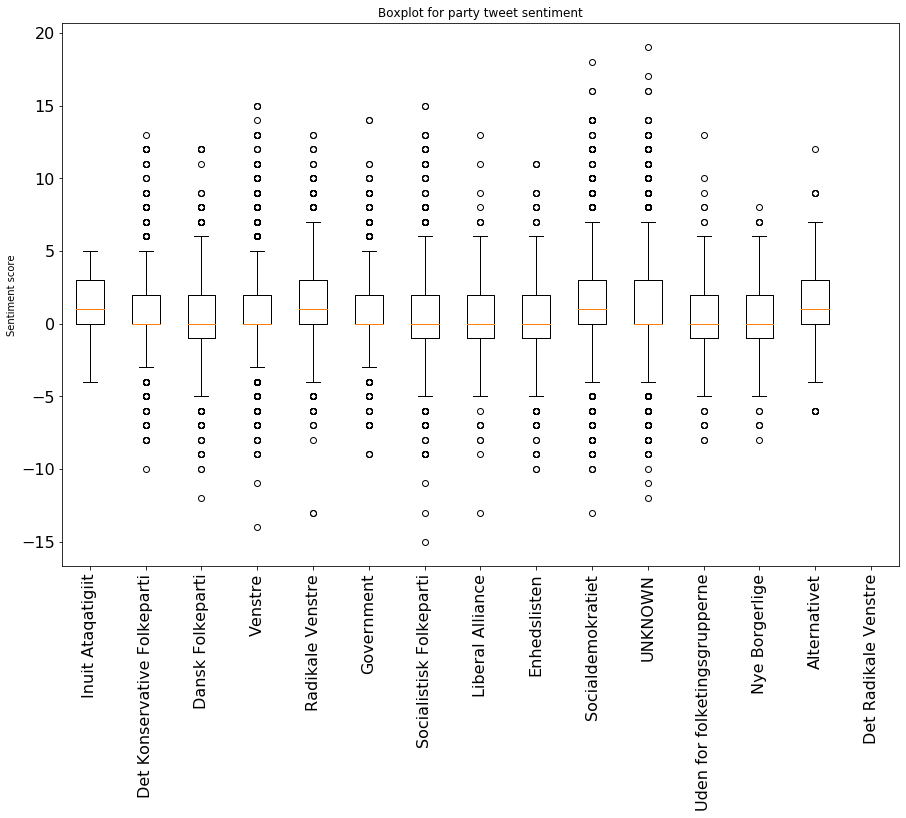

In [63]:
#### Plotting a relationship graph# for each party get statistics and make plot
box_labels = []
_scores = []

for key, value in total_sentiment.items():
    box_labels.append(key)
    score_l = []
    for inner in value.values():
        score = inner['scores']
        #print(score)
        score_l.extend(score)
    _scores.append(score_l)
print(len(_scores))

#The results are a bit mixed, we see dansk folkeparti agreeing the most with det konservative, and det konservative to venstre as these are all blue block members, however enhedslisten agrees most with Radikale, which is not the same block. Same thing can be said for Venstre -> Radikale and Liberal -> Radikale. This could suggest that the current block politic strategy might be a bit flawed. However it must also be considered that there are a lot of unknown parties so the truth could be burried in decrypting this data.
print((_scores))

fig = plt.subplots(figsize=(15,10))
plt.tick_params(labelsize=16)
plt.xticks(rotation=90)
plt.ylabel('Sentiment score')
plt.title("Boxplot for party tweet sentiment")
plt.boxplot(_scores, labels=box_labels)
plt.show()



In [ ]:
#### Plotting a relationship graph

## Analysis step 4:  Parliament+twitter topics (FREDERIK)

## Analysis step 5: Sentiment (CHRISTIAN)

## Analysis step 6: Tying together

# Discussion

Mette Frederiksen er feks ikke med...


Tidspunkter for tweets vs. tider for meeetings.

Kan politikere skifte holdninger..


Flere tweets?

Forskel på hvor mange tweets folk har

# Constributions

"You should write (just briefly) which group member was the main responsible for which elements of the assignment. (I want you guys to understand every part of the assignment, but usually there is someone who took lead role on certain portions of the work. That’s what you should explain)."

**Christian:**<p>
All of the following section has Christian has the main responsible for the following sections. For these sections, Christian has done all coding + all vizualisations, text regarding methods/theory and conclusions on all of the analysises.
    
Explainer notebook<p>  
    
* Describe datasets: Describe Politicians (parties and regions)
* Data cleaning: Politicians (parties and regions) 
* Tools, theory and analysis: Analysis step 3: Parties and wordclouds
* Tools, theory and analysis: Analysis step 5: Sentiment 

Website <p>
    
* dddd
* ddddd

**Frederik:**<p>
All of the following section has Frederik has the main responsible for the following sections. For these sections, Frederik has done all coding + all vizualisations, text regarding methods/theory and conclusions on all of the analysises.
    
Explainer notebook<p> 

* Describe datasets: Describe Political meetings 
* Data cleaning: Political meetings
* Preliminary statistics, Text statistics (twitter and meetings): Meetings text statistics 
* Tools, theory and analysis: "Analysis step 4: Parliament+twitter topics" 


Website <p>
    
* dddd
* ddddd

**Lau:**<p>
All of the following section has Lau has the main responsible for the following sections. For these sections, Lau has done all coding + all vizualisations, text regarding methods/theory and conclusions on all of the analysises.

Explainer notebook<p> 

* Describe dataset -> Describe Twitter
* Datacleaning: Twitterprofiles
* Datacleaning: Tweets (who tags who) [Tweets-(who-tags-who)](#Tweets-(who-tags-who))
* Datacleaning: Tweets (only text)
* Preliminary statistics, Text statistics (twitter and meetings): Twitter text statistics (who mentions who)
* Preliminary statistics, Text statistics (twitter and meetings): Twitter text statistics (last 200 tweets for every politician)
* Preliminary statistics: Network statistics
* Tools, theory and analysis: "Analysis step 1: Network"
* Tools, theory and analysis: "Analysis step 2: Community detection and wordclouds"

   
Website <p>
    
* Data, Twitterdata
* Network analysis: Preliminary statistics
* Network analysis: Community detection
* Network analysis: House of card - the danish version


   
   
   
   

MANGLER
Analysis step 6: Tying together
Discussion

Laus website plots!


    



In [ ]:
#If degree weight should in the light of these results in fact also depend on the in_degree. One could assume that 

#Maybe the weights should be normalized by the number of edges conneting to the node

In [ ]:
#d_weight = dict(G.degree(G.nodes(),'weight'))

In [ ]:
#d_in = dict(G.in_degree(G.nodes()))

In [ ]:
#d_norm=dict()
#for node in list(d_weight.keys()):
#    if d_in[node]==0:
#        d_norm.update({node:d_weight[node]})
#    else:
#        d_norm.update({node:d_weight[node]/d_in[node]})
            

In [ ]:
#start=list(dict(G.degree(["vestager"])).values())[0]
#print(start)
#end=list(dict(G.degree(["vestager"],'weight')).values())[0]
#print(end)

In [ ]:
#d_norm["vestager"]

In [ ]:
#plt.figure(figsize=(10,20))
#nx.draw_kamada_kawai(G, node_size=[v * 0.1 for v in d_norm.values()], width=0.1)

#plt.title("Nice visualization of the total network with normalized weight-degree",fontsize=18)
#plt.show()